## MCMC

Posterior distribution:

$$P(x) = (1-a)\frac{x^{k-1}}{\Gamma(k)\tau^{k}}\exp\left( -\frac{x}{\tau}\right) + a\frac{1}{\pi w}\frac{w^2}{[(x - x_0)^2 + w^2]}$$

```
term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)   # pmisc
term2 = (1 / (np.pi * w)) * (w**2) / ((x - x0)**2 + w**2)       # pcauchy
```

where:
$$x \equiv \frac{r_{\rm offset}}{R_\lambda}$$


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
import seaborn as sns

import pickle

from glob import glob
import numpy as np
import struct

#import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
#from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.io import fits

from scipy.stats import chi2
from scipy.special import gamma

import pandas as pd
from tqdm import tqdm
import math

import pickle
#from matched_clusters import matched_clusters
#from matched_clusters_plot import *

from astropy.table import Table
import emcee
import pygtc

In [3]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    
plot_prettier()

In [4]:

## Read the saved matched clusters. 
matched_pkl = 'cosmodc2_matched_cloonan.pkl'
    
with open(matched_pkl, 'rb') as inp:
    matched_cl = pickle.load(inp)
    
matched_cl.columns

<TableColumns names=('mem_match_id','ra','dec','z','refmag','refmag_err','lambda','lambda_e','z_lambda','z_lambda_e','cg_spec_z','z_spec_init','z_init','r_lambda','r_mask','scaleval','maskfrac','zred','zred_e','zred_chisq','chisq','z_lambda_niter','ebv_mean','lnlamlike','lncglike','lnlike','ra_orig','dec_orig','w','dlambda_dz','dlambda_dz2','dlambdavar_dz','dlambdavar_dz2','z_lambda_raw','z_lambda_e_raw','bkg_local','lim_exptime','lim_limmag','lim_limmag_hard','lambda_c','lambda_ce','ncent_good','maskgal_index','mag','mag_err','pzbins','pz','ra_cent','dec_cent','id_cent','lambda_cent','zlambda_cent','p_cen','q_cen','p_fg','q_miss','p_sat','p_c','comvd','matched','centered','halo_ID','halo_RA','halo_Dec','halo_z','halo_M','halo_comv','propD_sep','z_sep')>

In [5]:
cols = ['mem_match_id','ra','dec','z','refmag'
        ,'refmag_err','lambda','lambda_e','z_lambda'
        ,'z_lambda_e','cg_spec_z','z_spec_init'
        ,'z_init','r_lambda','r_mask','scaleval'
        ,'maskfrac','zred','zred_e','zred_chisq'
        ,'chisq','z_lambda_niter','ebv_mean'
        ,'lnlamlike','lncglike','lnlike'
        ,'ra_orig','dec_orig','w','dlambda_dz'
        ,'dlambda_dz2','dlambdavar_dz'
        ,'dlambdavar_dz2','z_lambda_raw'
        ,'z_lambda_e_raw','bkg_local','lim_exptime'
        ,'lim_limmag','lim_limmag_hard','lambda_c'
        ,'lambda_ce','ncent_good','maskgal_index'
        ,'comvd','matched','centered','halo_ID'
        ,'halo_RA','halo_Dec','halo_z','halo_M'
        ,'halo_comv','propD_sep','z_sep']

In [6]:
misc_cl = matched_cl[cols][matched_cl['centered'] == False].to_pandas()
misc_cl['r_lambda']

0      0.948721
1      0.876661
2      0.836278
3      0.844654
4      0.804001
         ...   
557    0.736058
558    0.755107
559    0.729066
560    0.739048
561    0.749584
Name: r_lambda, Length: 562, dtype: float32

## Extract parameters 

Quantities needed:
* Z_SPT, 
* xi
* theta_core
* M500c
* beam = 1.3, given 
* propD_sep

Derived quantities include:
* R500c
* theta_500
* x_offset

In [7]:
##Convert radius to angle
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
#cosmo.arcsec_per_kpc_proper(0.5).value

In [8]:
misc_cl['offset_Rlambda'] = misc_cl.apply(lambda row: (row['propD_sep']/1000)/(row['r_lambda']), axis = 1)

In [9]:
misc_cl['offset_Rlambda']

0      0.101166
1      0.281461
2      0.439654
3      0.075147
4      0.159507
         ...   
557    0.239189
558    0.072373
559    0.117321
560    0.177131
561    1.207756
Name: offset_Rlambda, Length: 562, dtype: float64

### Building the Offset Model

In [10]:
#Now let's try to write down the likelihood function

def misc_dist(x, *args):
    
    params = args[0]
    
    tau = params[0]; 
    w = params[1]; 
    a = params[2]
    
    term1 = x * np.exp(-x/tau)
    
    term2 = np.zeros_like(x)
    inds = (x < w)
    term2[inds] = 1
    
    px = (a * term1) + (term2)
    
    return px

def lnlike_frlambda(params, *args):
    #tau, a, x0, gamma, b = params
    #tau, x0, gamma = params
    
    k = 2
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    tau, w, a = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    term2 = (w * x) / (x**2 + w**2)**1.5
    
    ### Cauchy with fiducial contamination fraction
    '''
    a = 0.22
    
    tau, w = params

    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    term2 = (w * x) / (x**2 + w**2)**1.5
    '''
    
    px = ((1 - a) * term1) + (a * term2)
    
    return np.sum(np.log(px))

In [11]:
#set priors on parameters  
def lnprior_frlambda(params):
    #tau, a, x0, gamma, b = params
    #tau, x0, gamma = params
    tau, w, a = params
    
    if ((0.0 < tau <= 1) 
        #& (0.0 < a <= 1) 
        #& (0.0 < b <= 5000) 
        & (0.0 < a <= 1.) 
        & (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

In [12]:
def lnprob_frlambda(params, *args):
    offset = args[0]
    lp = lnprior_frlambda(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_frlambda(params,offset)

### Begin Sampling

In [13]:
#let's start the chain the amoeba minimization values
result = [0.1
          #, 100
          , 3
          , 0.15
          #, 0.5
         ]
ndim,nwalkers = 3, 30  #debugging
pos = [result + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
#now try to run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frlambda, args=[misc_cl['offset_Rlambda']])
sampler.run_mcmc(pos,1000, progress=True)

 28%|██▊       | 278/1000 [00:11<00:23, 30.62it/s]Traceback (most recent call last):
  File "/global/homes/a/acloonan/.conda/envs/aidan_env/lib/python3.6/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-b51c21c40508>", line 6, in lnprob_frlambda
    return lp + lnlike_frlambda(params,offset)
  File "<ipython-input-10-8121631bd7db>", line 34, in lnlike_frlambda
    term2 = (w * x) / (x**2 + w**2)**1.5
  File "/global/homes/a/acloonan/.conda/envs/aidan_env/lib/python3.6/site-packages/pandas/core/ops/common.py", line 65, in new_method
    return method(self, other)
  File "/global/homes/a/acloonan/.conda/envs/aidan_env/lib/python3.6/site-packages/pandas/core/ops/__init__.py", line 345, in wrapper
    return left._construct_result(result, name=res_name)
  File "/global/homes/a/acloonan/.conda/envs/aidan_env/lib/python3.6/site-packages/pandas/core/series.py", line 2770, in _construct_result
    out = self._cons

emcee: Exception while calling your likelihood function:
  params: [0.1353     1.4473144  0.05727508]
  args: [0      0.101166
1      0.281461
2      0.439654
3      0.075147
4      0.159507
         ...   
557    0.239189
558    0.072373
559    0.117321
560    0.177131
561    1.207756
Name: offset_Rlambda, Length: 562, dtype: float64]
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [93]:
samples = sampler.chain[:,200:, :].reshape((-1, ndim))
samples.shape

(24000, 3)

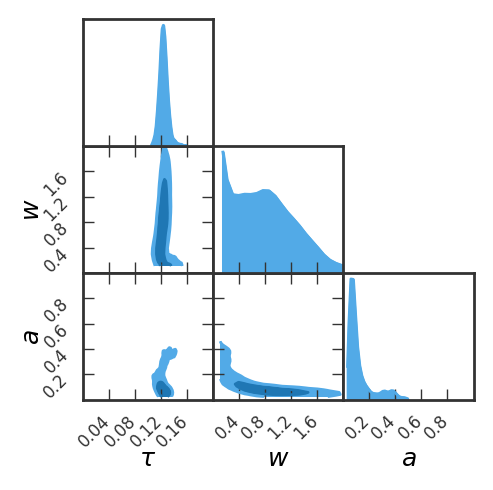

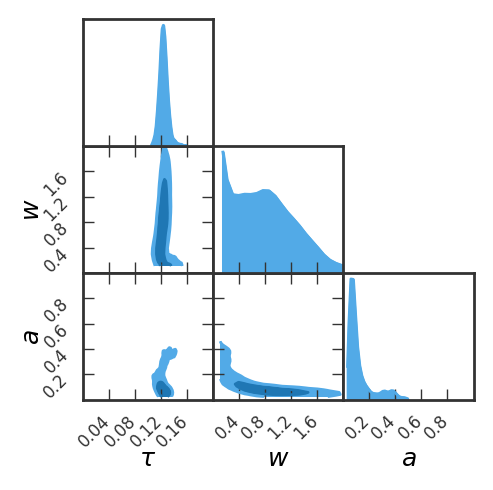

In [96]:
#param_ranges = [[0.0, 1.0]]
param_ranges = [[0., 0.2], [0, 2], [0, 1]]
#param_ranges = [[0.1, 5000],[0., 1], [0, 5000], [0, 5000], [0, 5000]]

names = [r'$\tau$', r'$w$', r'$a$']
#names = [r'$A$', r'$\tau$', r'$B$', r'$x_0$', r'$\gamma$']

pygtc.plotGTC(chains=samples, figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges)
#fig = pygtc.pygtc.__plot1d()(samples,figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges, plotName='sample_sptpol100d_offset.pdf'
                             #, customLabelFont ={'family':'Arial', 'size':10}, customTickFont ={'family':'Arial', 'size':6} , colorsOrder =['blues']             )
#plt.hist(samples[:,4], bins=75, density=True)
#plt.xlabel(r'$\tau$')


In [97]:
params_fit = np.median(samples, axis=0)
params_16p = np.percentile(samples, 16, axis=0)
params_84p = np.percentile(samples, 84, axis=0)

In [140]:
print(params_16p)
print(params_fit)
print(params_84p)

[0.11781525 0.22856985 0.05431065]
[0.1232863  0.73562044 0.07867118]
[0.12928513 1.28508349 0.19357446]


In [10]:
def plot_trace(x, params, cutoff = 900, figsize=(10, 3)):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[2]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    medians = np.median(x, axis=1)
    
    sig_lb = np.percentile(x, 16, axis=1)
    sig_ub = np.percentile(x, 84, axis=1)
        
    #plt.figure(figsize=figsize)
    for d in range(ndims):
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
        ax.set_ylabel(r'${}$'.format(params[d])) # label axis 
        ax.set_xlabel(r'step number')
        
        if ndims == 1:
            
            avr = np.mean(medians[-100:])
            
            sig_lb = sig_lb.reshape(sig_lb.shape[0])
            sig_ub = sig_ub.reshape(sig_ub.shape[0])
            
            xl = np.linspace(-50, len(medians)+50, 50)  # average
            yl = 0 * xl + avr
            
            xc = 0 * xl + cutoff
    
            ax.plot(xl, yl, '--', c='r', lw=1.0)
            ax.plot(xc, xl, '--', c='g', lw=1.0)

            ax.set_xlim(-25, len(medians) + 25)
            ax.set_ylim(np.min(medians) * 0.85, np.max(medians) * 1.15)
        
            ax.plot(np.arange(0,nsteps,1), medians, alpha=0.75, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
            ax.fill_between(np.arange(0,nsteps,1), sig_lb, sig_ub, alpha=0.2)
        
        else:
            
            avr = np.mean(medians[:,d][-100:])
            
            xl = np.linspace(-50, len(medians[:,d])+50, 50)
            yl = 0 * xl + avr
            
            xc = 0 * xl + cutoff
    
            ax.plot(xl, yl, '--', c='r', lw=1.0)
            ax.plot(xc, xl, '--', c='g', lw=1.0)

            ax.set_xlim(-25, len(medians[:,d]) + 25)
            ax.set_ylim(np.min(medians[:,d]) * 0.97, np.max(medians[:,d]) * 1.03)
            
            ax.plot(np.arange(0,nsteps), medians[:,d], alpha=0.75, lw=0.75, c='darkblue', label='d={:d}'.format(d))
            ax.fill_between(np.arange(0,nsteps), sig_lb[:,d], sig_ub[:,d], color='darkblue', alpha=0.2)

In [100]:
results = sampler.get_chain()
results.shape

(1000, 30, 3)

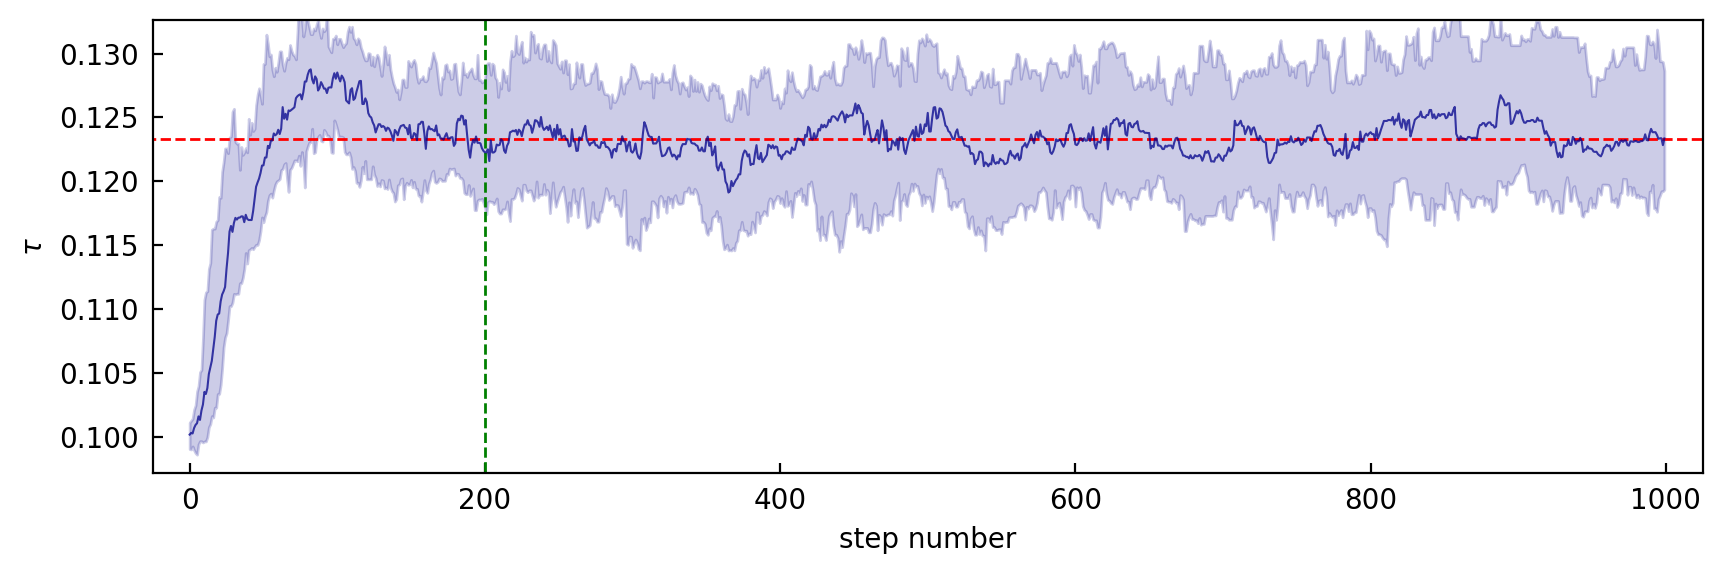

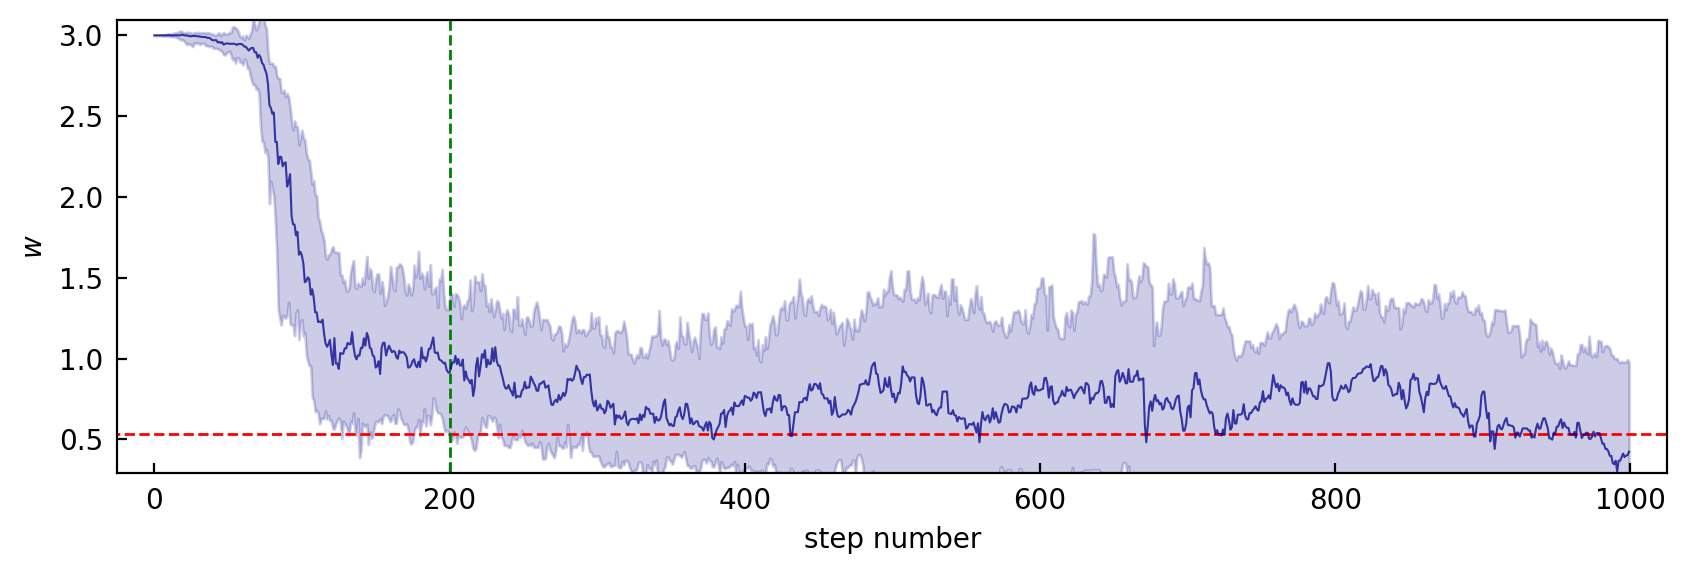

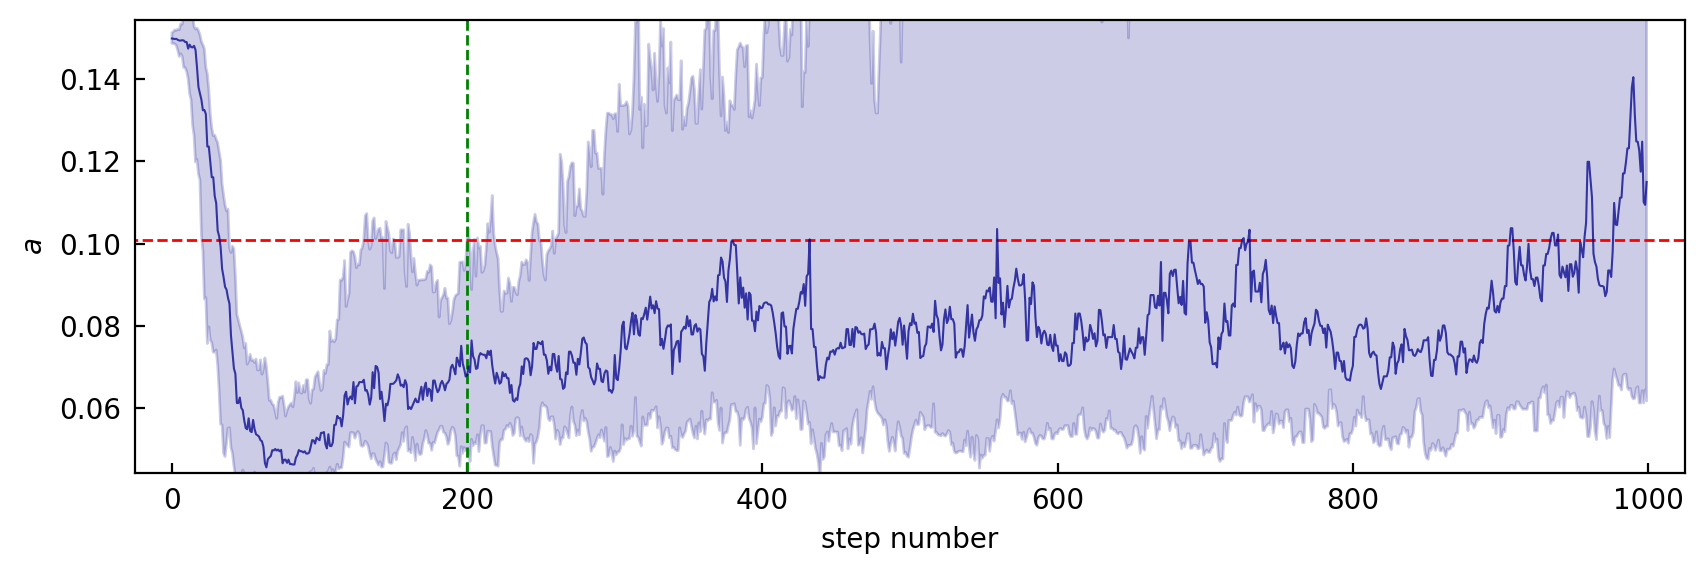

In [101]:
params_lst = [r'\tau', r'w', r'a']
#params_lst = ['a', 'b', 'c']

plot_trace(results, params_lst)

In [80]:
x = np.linspace(0, 3, 10000)

tau = params_fit.copy()

def p(x, k=2):
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    #term2 = np.zeros_like(x)
    #inds = (x < w)
    #term2[inds] = 1 / w
    
    #term2 = (w * x) / (x**2 + w**2)**1.5
    
    px = term1.copy()
    #px = ((1 - a) * term1) + (a * term2)
    
    return px#, (1 - a) * term1, a * term2

px = p(x)
#px, pmisc, p2 = p(x)
print(np.sum(px))

3332.9984432531105


In [81]:
misc_cl['offset_Rlambda'][misc_cl['offset_Rlambda'] > 1].shape

(25,)

In [82]:
# NOT normalized

#bins = np.linspace(0, np.max(misc_cl['offset_Rlambda']), 100)

h = np.histogram(misc_cl['offset_Rlambda'], bins='auto', density=False)


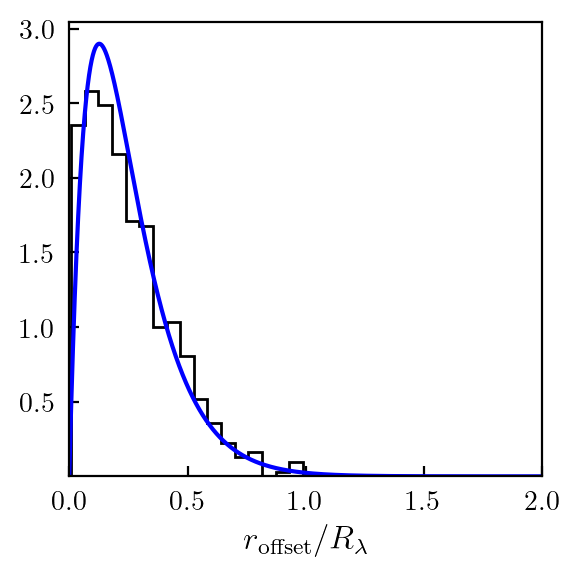

In [83]:
# normalized

plt.figure(figsize=(3,3))
h_norm = plt.hist(offset, bins='auto', density=True, histtype='step', fill=False, color='black')
plt.plot(x, px, 'blue', label=r'$P_{\rm tot}$')
#plt.plot(x, pmisc, 'r', label=r'$P_{\gamma}$')
#plt.plot(x, p2, 'b', label=r'$P_{\rm cau}$')
plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=12)
#plt.ylabel('density = True', fontsize=12)
plt.yscale('linear')
plt.xlim(0, 2)
plt.ylim(1e-3)

plt.tight_layout()

plt.savefig('gamma_fit_no_outliers.jpg', format='jpg')


In [146]:
# next, calculate chi2

xos = np.array([])

for i, num in enumerate(h_norm[1][:-1]):
    num2 = h_norm[1][i+1]
    xos = np.append(xos, (num+num2)/2)
    
yos = h_norm[0]

pxos = p(xos)[0]

In [147]:
ind = 0
norm_const = (h[0][ind] / yos[ind])

# calculate uncertainty
yos_err = np.sqrt(h[0]) / norm_const

In [148]:
from scipy.stats import chi2

def calc_chi2(obs, model, err, npar=3):
    
    obs = np.array(obs)
    model = np.array(model)
    err = np.array(err)
    
    non_zeros = (obs != 0)
    
    pchi2 = ((obs[non_zeros] - model[non_zeros]) / err[non_zeros])**2
    
    e2 = np.sum(pchi2)
    ddof = pchi2.size - npar   # number of degrees of freedom
    
    pvalue = 1 - chi2.cdf(e2, ddof)
    
    redchi2 = e2 / ddof  # reduced chi2
    print(e2, ddof)
    
    return redchi2, pvalue

In [149]:
redchi2, pvalue = calc_chi2(yos, pxos, yos_err)
redchi2, pvalue

36.93807494661843 31


(1.1915508047296268, 0.21352080917386007)

### Testing Different Models

In [16]:

def calc_chi2(obs, model, err, npar=3):
    
    obs = np.array(obs)
    model = np.array(model)
    err = np.array(err)
    
    non_zeros = (obs != 0)
    
    pchi2 = ((obs[non_zeros] - model[non_zeros]) / err[non_zeros])**2
    
    e2 = np.sum(pchi2)
    ddof = pchi2.size - npar   # number of degrees of freedom
    
    pvalue = 1 - chi2.cdf(e2, ddof)
    
    redchi2 = e2 / ddof  # reduced chi2
    print(e2, ddof)
    
    return redchi2, pvalue

def test_model(log_post, log_like, offset, init, nsteps=1000, nwalkers=30):
    '''
    run an MCMC for some defined log(posterior) PDF function and return result
    and chi2, p, AIC values
    '''
    
    ndim = len(init)
    pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    
    #now try to run emcee
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frlambda, args=[offset])
    sampler.run_mcmc(pos,nsteps, progress=True)
    
    results = sampler.get_chain()
    samples = sampler.chain[:,-300:, :].reshape((-1, ndim))
    
    #params_fit = sampler.<function> maximum likelihood estimator
    
    params_fit = np.median(samples, axis=0)
    
    x = np.linspace(0, 2, 10000)
    
    px = log_like(params_fit, x)[1]
    
    h = np.histogram(offset, bins='auto', density=False)
    h_norm = np.histogram(offset, bins='auto', density=True)
    
    xos = np.array([])

    for i, num in enumerate(h_norm[1][:-1]):
        num2 = h_norm[1][i+1]
        xos = np.append(xos, (num+num2)/2)
    
    yos = h_norm[0]
    pxos = log_like(params_fit, xos)[1]
    
    norm_const = (h[0][0] / yos[0])

    # calculate uncertainty
    yos_err = np.sqrt(h[0]) / norm_const
    
    redchi2, pvalue = calc_chi2(yos, pxos, yos_err)
    
    # calculate AIC
    maxloglike = log_like(params_fit, offset)[0]
    
    aic = 2*ndim - 2*maxloglike
    
    return results, samples, params_fit, (redchi2, pvalue, aic)
        
def plot_fit(offset, px, pmisc, p2, figsize=(3,3), lim=4, scale='linear'):
    
    plt.figure(figsize=figsize)
    plt.hist(offset, bins='auto', density=True, histtype='step', fill=False, color='black')
    plt.plot(x, px, 'black', label=r'$P_{\rm tot}$')
    plt.plot(x, pmisc, 'r', label=r'$P_{\gamma}$')
    plt.plot(x, p2, 'b', label=r'$P_{\rm cau}$')
    plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=12)
    
    plt.legend(loc = 'upper right')

    plt.yscale(scale)
    plt.xlim(0, lim)
    plt.ylim(1e-3)

In [334]:
def lnlike_frlambda(params, *args):
    
    k = 2
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    ####################
    
    ### using Cauchy function
    '''
    tau, w, a = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    term2 = (w * x) / (x**2 + w**2)**1.5
    '''
    
    ### using Cauchy with fiducial contamination fraction
    '''
    a = 0.22
    
    tau, w = params

    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    term2 = (w * x) / (x**2 + w**2)**1.5
    '''
    
    ### using tophat function
    '''
    tau, w, a = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    term2 = np.zeros_like(x)
    inds = (x < w)
    term2[inds] = 1 / w
    '''
    
    ### using tophat with fiducial contamination
    '''
    a = 0.22
    
    tau, w = params

    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    term2 = np.zeros_like(x)
    inds = (x < w)
    term2[inds] = 1 / w
    '''
    
    ### using a different Cauchy formulation with peak location
    
    tau, x0, w, a = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)   # pmisc
    term2 = (1 / (np.pi * w)) * (w**2) / ((x - x0)**2 + w**2)       # pcauchy
    
    pmisc = (1 - a) * term1
    p2 = a * term2
    
    px = pmisc + p2
    
    
    ### only with tau
    
    '''
    tau = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)   # pmisc
    
    px = term1.copy()
    '''
    
    ### different Cauchy formulation with a = 0.22
    '''
    a = 0.22
    tau, x0, w = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    term2 = (1 / (np.pi * w)) * (w**2) / ((x - x0)**2 + w**2)
    '''
    
    ####################
    
    #if len(params)==1:
    #    return np.sum(np.log(px)), px
    
    return np.sum(np.log(px)), px, pmisc, p2

#set priors on parameters  
def lnprior_frlambda(params):
    
    #k = 2

    tau, x0, w, a = params
    #a = 0.22
    #tau = params
    
    if ((0.0 < tau <= 1) 
        #& (1e-3 < k < 10)
        & (1e-3 < x0 < 100)
        & (0.0 < a <= 1.) 
        & (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

def lnprob_frlambda(params, *args):
    
    offset = args[0]
    lp = lnprior_frlambda(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    ll = lnlike_frlambda(params,offset)[0]
    
    return lp + ll

In [335]:
ind = ((misc_cl['lambda'] > 40) 
       & (misc_cl['z'] > 0.2) 
       & (misc_cl['z'] < 1.)
      )

#offset = misc_cl['offset_Rlambda']#[misc_cl['lambda'] > 40]
#offset = roffset_low
offset = misc_cl['offset_Rlambda'][ind]
print(len(offset))

67


In [336]:
#plt.hist(offset)

In [337]:

init = [.15
        , 2
        , 0.5
        , .15
        #, 2
       ]

results, samples, params_fit, fit_eval = test_model(lnprob_frlambda, lnlike_frlambda
                                                    , offset, init
                                                    , nsteps=1200, nwalkers=35)

100%|██████████| 1200/1200 [00:54<00:00, 22.07it/s]

13.707339759689015 7


In [338]:
print(params_fit)

[1.13075777e-01 5.19530409e+01 1.35341223e+02 8.32767481e-03]


In [339]:
# print fit evaluation values

print('chi2    :',fit_eval[0])
print('p-value :',fit_eval[1])
print('aic     :',fit_eval[2])

chi2    : 1.9581913942412879
p-value : 0.056638259393009815
aic     : -68.04190828479709


([array([10500.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.]),
  array([940., 480., 542., 405., 513., 454., 555., 561., 512., 597., 541.,
         606., 410., 462., 437., 477., 439., 379., 532., 521., 137.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([542., 1

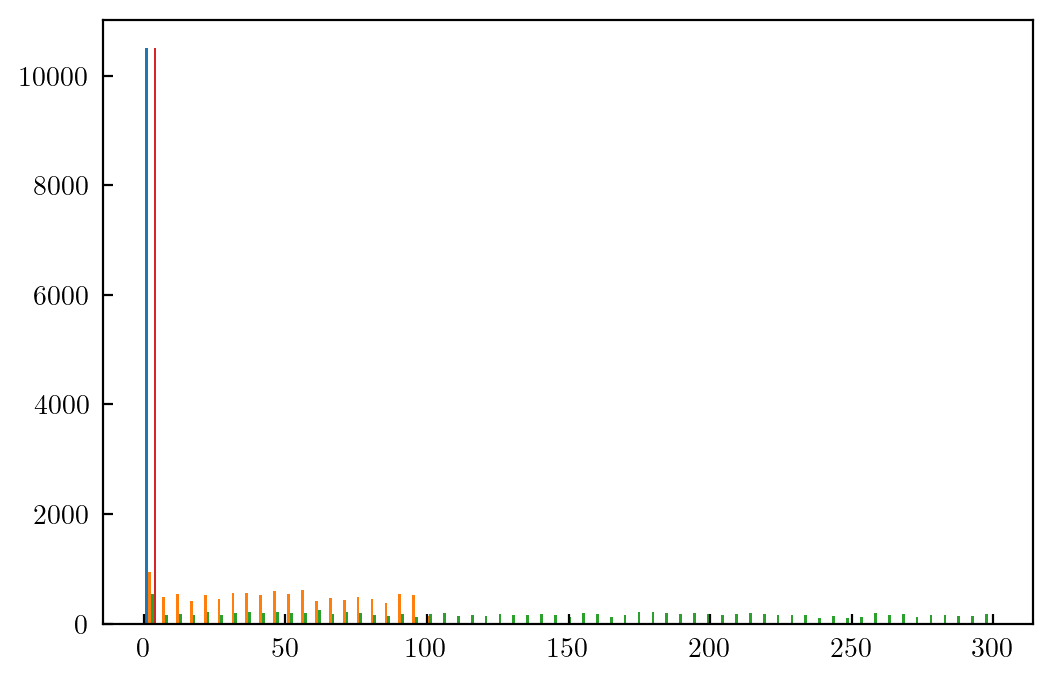

In [224]:
plt.hist(samples, bins=61)

<Figure size 600x600 with 0 Axes>

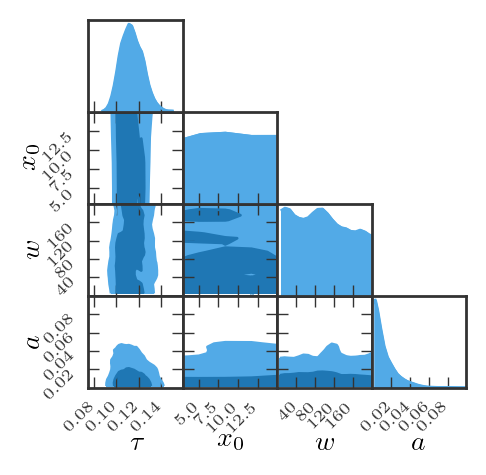

In [345]:
# GTC plot

param_ranges = [[0.075, 0.16], [3, 15]
                , [0, 200]
                , [0, 0.1]#, [0,1e-2]
                ]
names = [r'$\tau$', r'$x_0$'
         , r'$w$'
         , r'$a$'#, r'$k$'
        ]

plt.figure(figsize=(3,3))

gtc = pygtc.plotGTC(chains=samples, figureSize='MNRAS_page'
                    ,paramNames=names,paramRanges=param_ranges
                    #, customTickFont={'family':'serif', 'size':4}
                    , mathTextFontSet='stixsans'
                    , customLabelFont = {'size':10}
                   )
#plt.text(-0.15, 150, s=r'$P_{\rm cau} = \frac{1}{\pi w}\frac{w^2}{[(x - x_0)^2 + w^2]}$', fontsize=8)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
#plt.tight_layout()
plt.savefig('figures/clean_gtc.pdf', bbox_inches='tight', format='pdf')

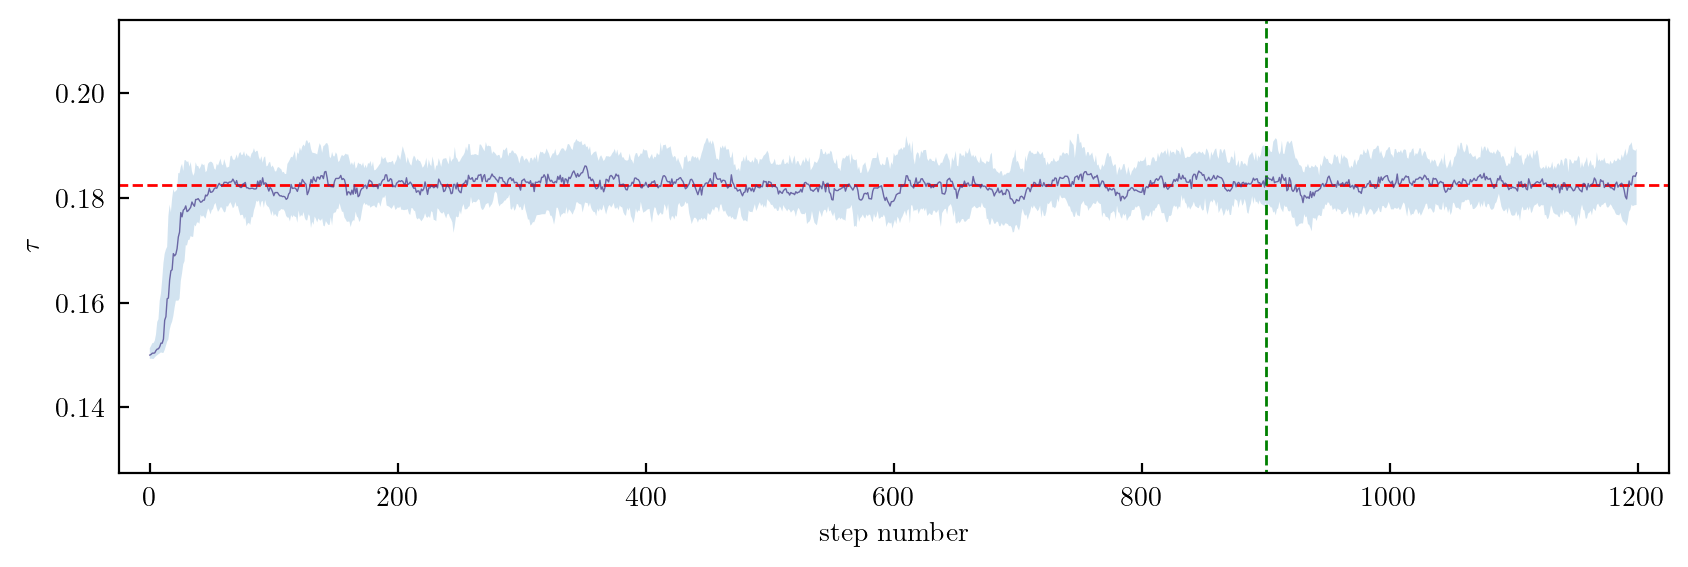

In [37]:
# trace plot
params_lst = [r'\tau'#, r'x_0'
              #, r'w'
              #, r'a'#, r'k'
             ]

plot_trace(results, params_lst)
#plt.savefig('figures/revised_cauchy_trace.pdf', format='pdf')

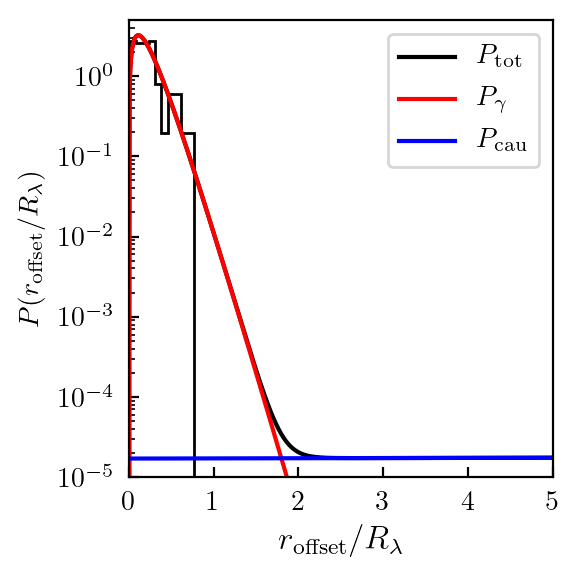

In [348]:
# plot fit

x = np.linspace(0, 100, 10000)
max_loglike, px, pmisc, p2 = lnlike_frlambda(params_fit, x)

plot_fit(offset, px, pmisc, p2, figsize=(3,3), scale='log')
plt.ylabel(r'$P(r_{\rm offset} / R_\lambda)$')
plt.xlim(0,5)
plt.ylim(1e-5,5)
#plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.tight_layout()
plt.savefig('figures/clean_fit.pdf', bbox_inches='tight', format='pdf')

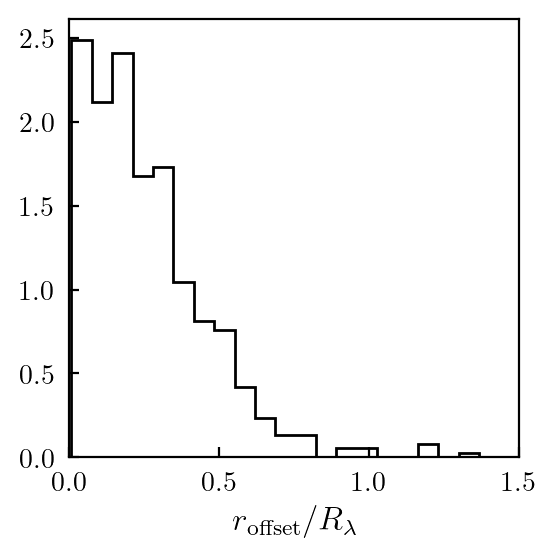

In [21]:
plt.figure(figsize=(3,3))
plt.hist(misc_cl['offset_Rlambda'], bins='auto', density=True, histtype='step', alpha=1
         , fill=False, color='black'
        )
plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=12)
#plt.ylabel('density = True', fontsize=12)
plt.yscale('linear')
plt.xlim(0, 1.5)
#plt.ylim(1e-3)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig('misc_dist_1.5.pdf', format='pdf')

Now with a set contamination fraction $a = 0.22$.

In [215]:
def lnlike_frlambda(params, *args):
    
    a = 0.22
    
    k = 2
    
    tau, w = params
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    #term2 = np.zeros_like(x)
    #inds = (x < w)
    #term2[inds] = 1 / w
    
    term2 = (w * x) / (x**2 + w**2)**1.5
    
    pmisc = (1 - a) * term1
    p2 = a * term2
    
    px = pmisc + p2
    
    return np.sum(np.log(px)), px, pmisc, p2

#set priors on parameters  
def lnprior_frlambda(params):

    tau, w = params
    
    if ((0.0 < tau <= 1) 
        #& (0.0 < a <= 1.) 
        & (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

In [125]:
init = [0.12, 1]

results_22, samples_22, params_fit_22, fit_eval_22 = test_model(lnprob_frlambda, lnlike_frlambda
                                                   , offset, init)

emcee: Exception while calling your likelihood function:
  params: [0.12035078 0.99855939]
  args: [0      0.101166
1      0.281461
2      0.439654
3      0.075147
4      0.159507
         ...   
557    0.239189
558    0.072373
559    0.117321
560    0.177131
561    1.207756
Name: offset_Rlambda, Length: 562, dtype: float64]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-124-a46133927dbf>", line 114, in lnprob_frlambda
    lp = lnprior_frlambda(params)
  File "<ipython-input-124-a46133927dbf>", line 106, in lnprior_frlambda
    & (0.0001 < w <= 300)
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [217]:
# print fit evaluation values

print('chi2    :',fit_eval_22[0])
print('p-value :',fit_eval_22[1])
print('aic     :',fit_eval_22[2])

chi2    : 1.265417684823668
p-value : 0.14739206281813155
aic     : -179.24718045475373


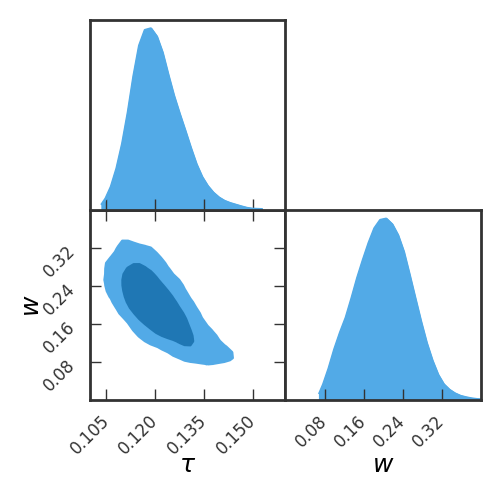

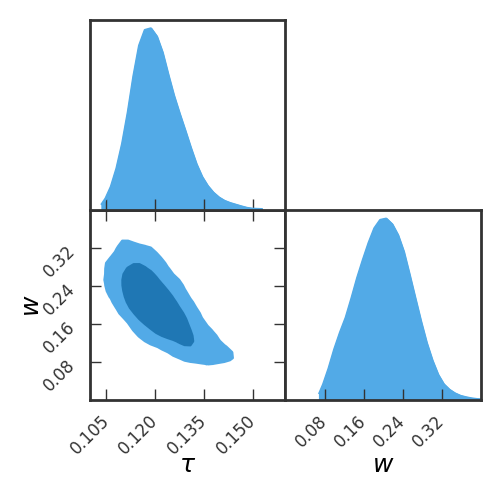

In [218]:
# GTC plot

param_ranges = [[0.1, 0.16], [0, 0.4]]
names = [r'$\tau$', r'$w$']
pygtc.plotGTC(chains=samples_22, figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges)

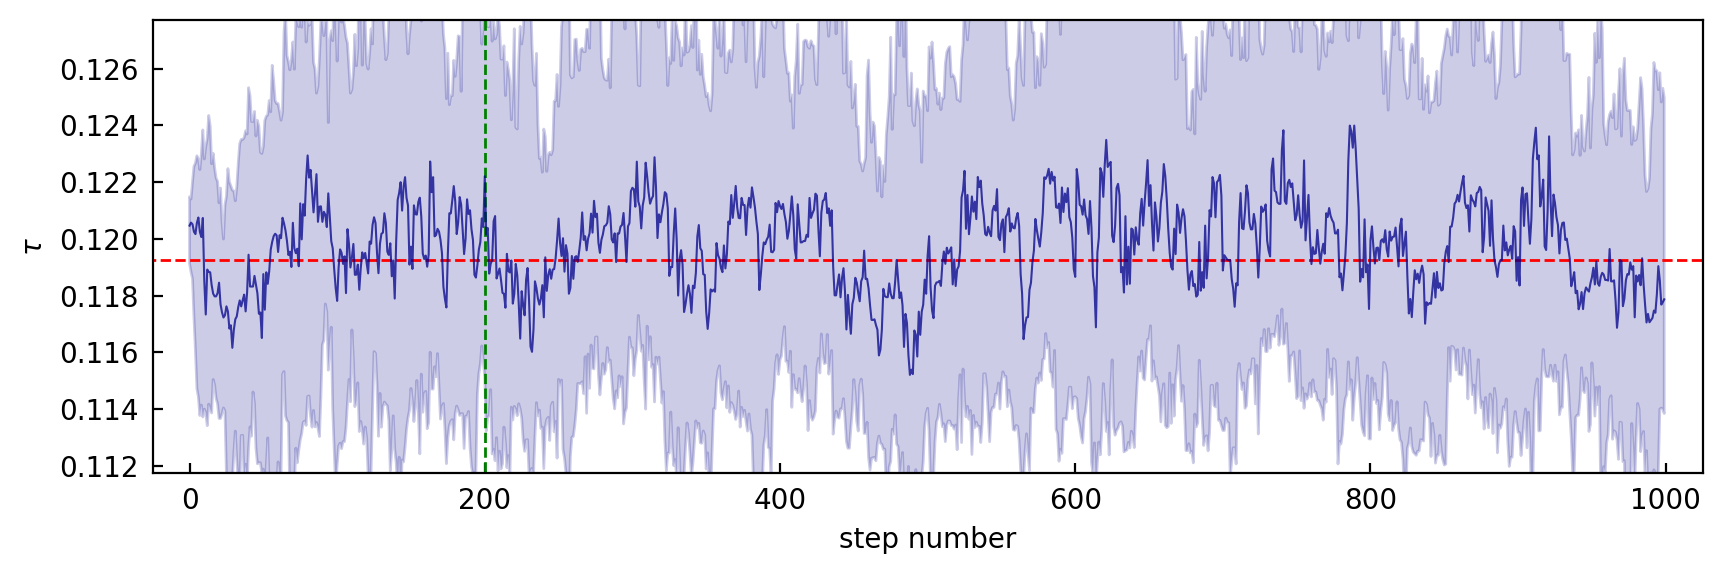

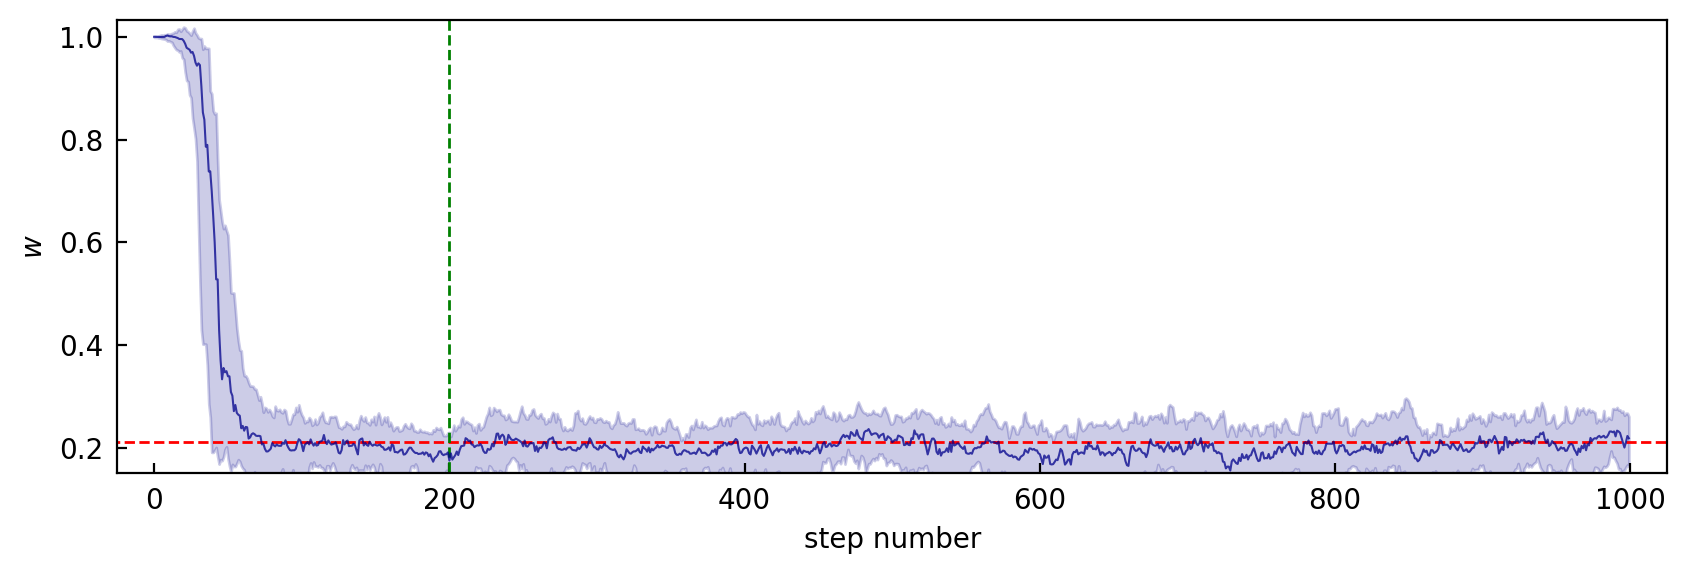

In [219]:
# trace plot
params_lst = [r'\tau', r'w']

plot_trace(results_22, params_lst)

/global/homes/a/acloonan/.conda/envs/aidan_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


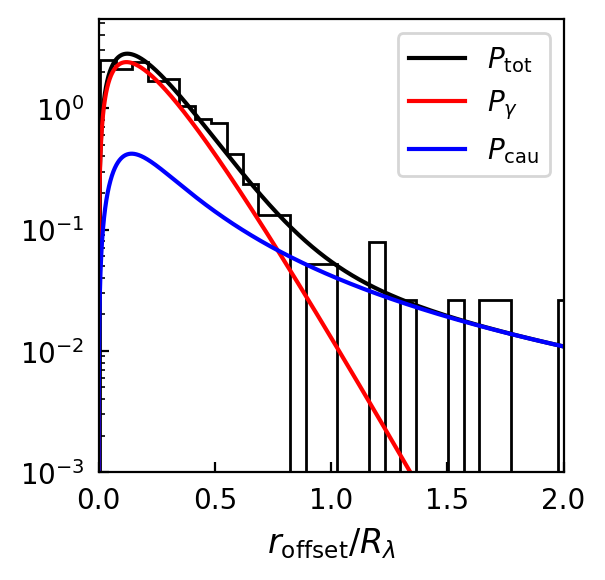

In [220]:
# plot fit

x = np.linspace(0, 2, 10000)
max_loglike, px, pmisc, p2 = lnlike_frlambda(params_fit_22, x)

plot_fit(px, pmisc, p2, scale='log')

#### Tophat

In [240]:
def lnlike_frlambda(params, *args):
    
    k = 2
    
    tau, w, a = params
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    term2 = np.zeros_like(x)
    inds = (x < w)
    term2[inds] = 1 / w
    
    #term2 = (w * x) / (x**2 + w**2)**1.5
    
    pmisc = (1 - a) * term1
    p2 = a * term2
    
    px = pmisc + p2
    
    return np.sum(np.log(px)), px, pmisc, p2

#set priors on parameters  
def lnprior_frlambda(params):

    tau, w, a = params
    
    if ((0.0 < tau <= 1) 
        & (0.0 < a <= 1.) 
        & (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

In [226]:
init = [0.12, 5, .15]

results_th, samples_th, params_fit_th, fit_eval_th = test_model(lnprob_frlambda, lnlike_frlambda
                                                   , offset, init)

100%|██████████| 1000/1000 [00:50<00:00, 19.69it/s]

34.24933988768936 31


In [227]:
# print fit evaluation values

print('chi2    :',fit_eval_th[0])
print('p-value :',fit_eval_th[1])
print('aic     :',fit_eval_th[2])

chi2    : 1.1048174157319148
p-value : 0.31449351966534445
aic     : -130.0746231701888


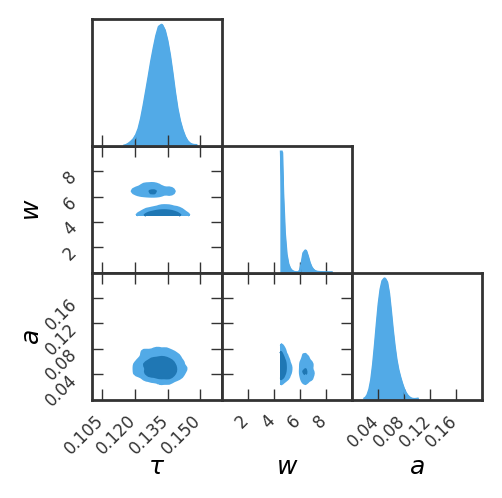

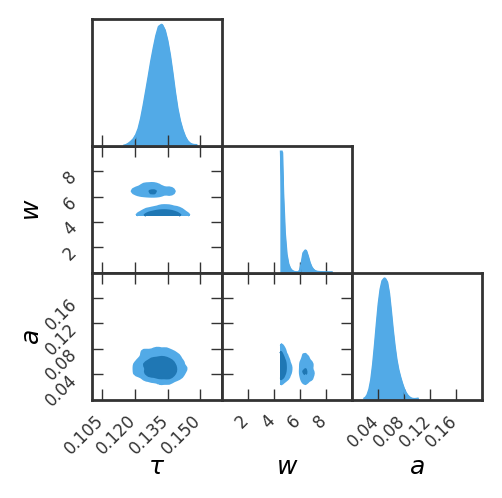

In [231]:
# GTC plot

param_ranges = [[0.1, 0.16], [0, 10], [0,0.2]]
names = [r'$\tau$', r'$w$', r'$a$']
pygtc.plotGTC(chains=samples_th, figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges)

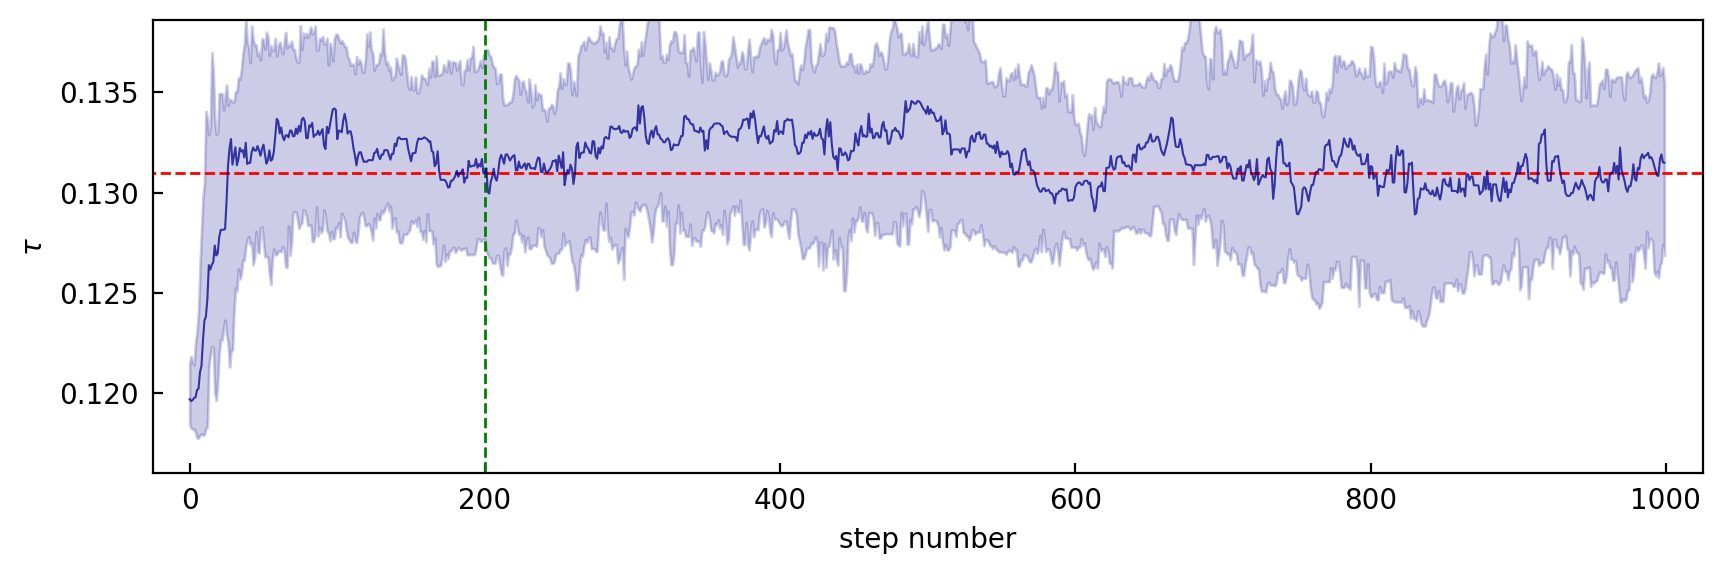

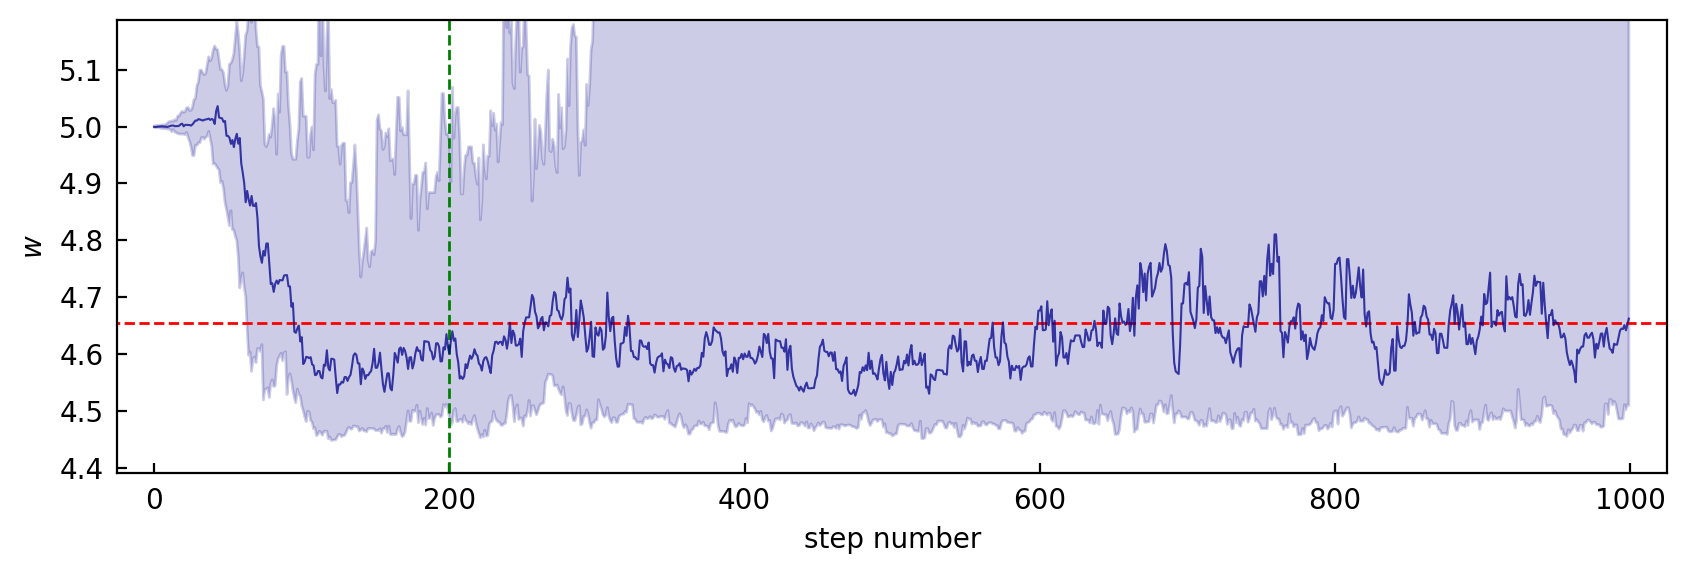

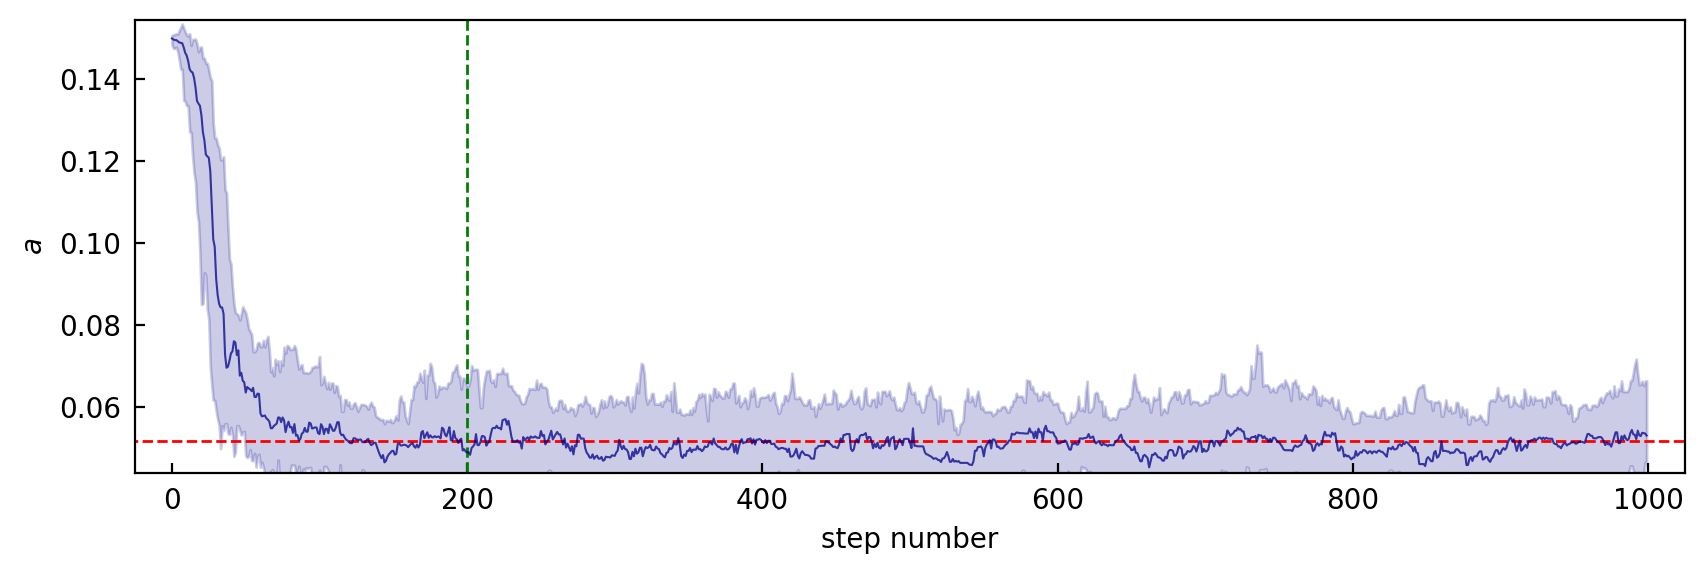

In [232]:
# trace plot
params_lst = [r'\tau', r'w', r'a']

plot_trace(results_th, params_lst)

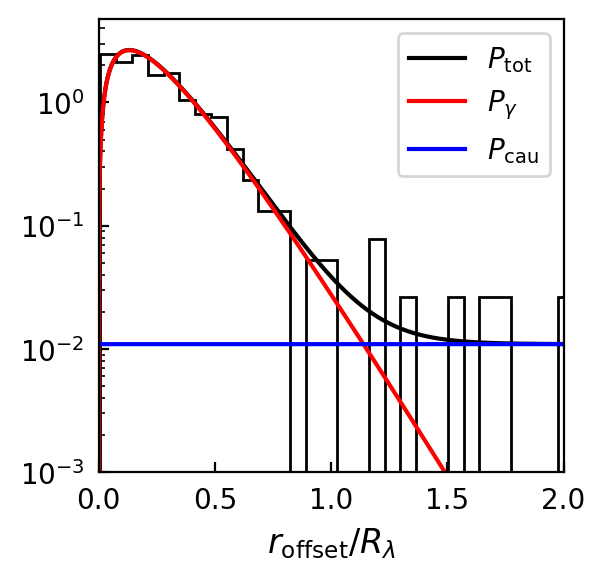

In [241]:
# plot fit

x = np.linspace(0, 2, 10000)
max_loglike, px, pmisc, p2 = lnlike_frlambda(params_fit_th, x)

plot_fit(px, pmisc, p2, scale='log')

Now, constrain the contamination fraction as before.

In [242]:
def lnlike_frlambda(params, *args):
    
    a = 0.22
    
    k = 2
    
    tau, w = params
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)
    
    term2 = np.zeros_like(x)
    inds = (x < w)
    term2[inds] = 1 / w
    
    #term2 = (w * x) / (x**2 + w**2)**1.5
    
    pmisc = (1 - a) * term1
    p2 = a * term2
    
    px = pmisc + p2
    
    return np.sum(np.log(px)), px, pmisc, p2

#set priors on parameters  
def lnprior_frlambda(params):

    tau, w = params
    
    if ((0.0 < tau <= 1) 
        #& (0.0 < a <= 1.) 
        & (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

In [243]:
init = [0.12, 4.5]

results_th22, samples_th22, params_fit_th22, fit_eval_th22 = test_model(lnprob_frlambda, lnlike_frlambda
                                                   , offset, init)

100%|██████████| 1000/1000 [00:51<00:00, 19.27it/s]

40.051314609550786 31


In [244]:
# print fit evaluation values

print('chi2    :',fit_eval_th22[0])
print('p-value :',fit_eval_th22[1])
print('aic     :',fit_eval_th22[2])

chi2    : 1.2919778906306705
p-value : 0.12788719371869117
aic     : -39.44788666059472


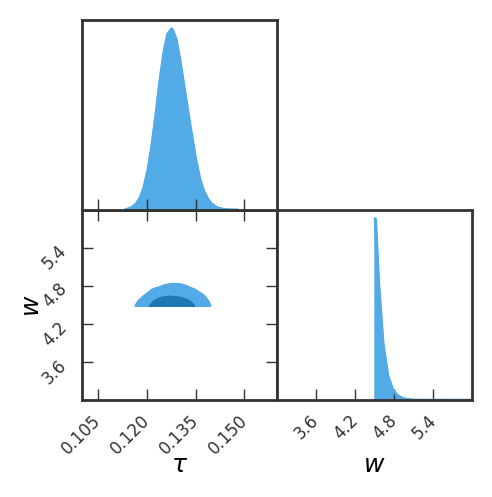

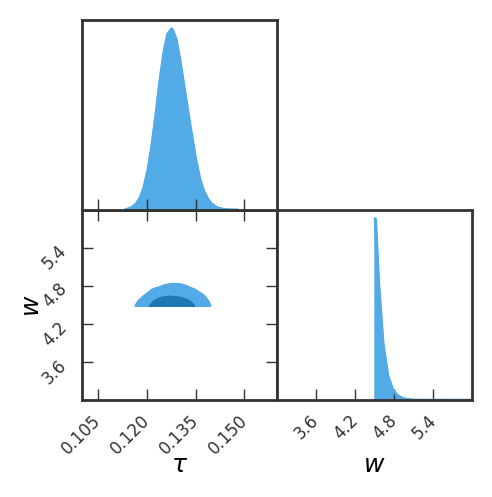

In [247]:
# GTC plot

param_ranges = [[0.1, 0.16], [3, 6]]
names = [r'$\tau$', r'$w$']
pygtc.plotGTC(chains=samples_th22, figureSize='MNRAS_page',paramNames=names,paramRanges=param_ranges)

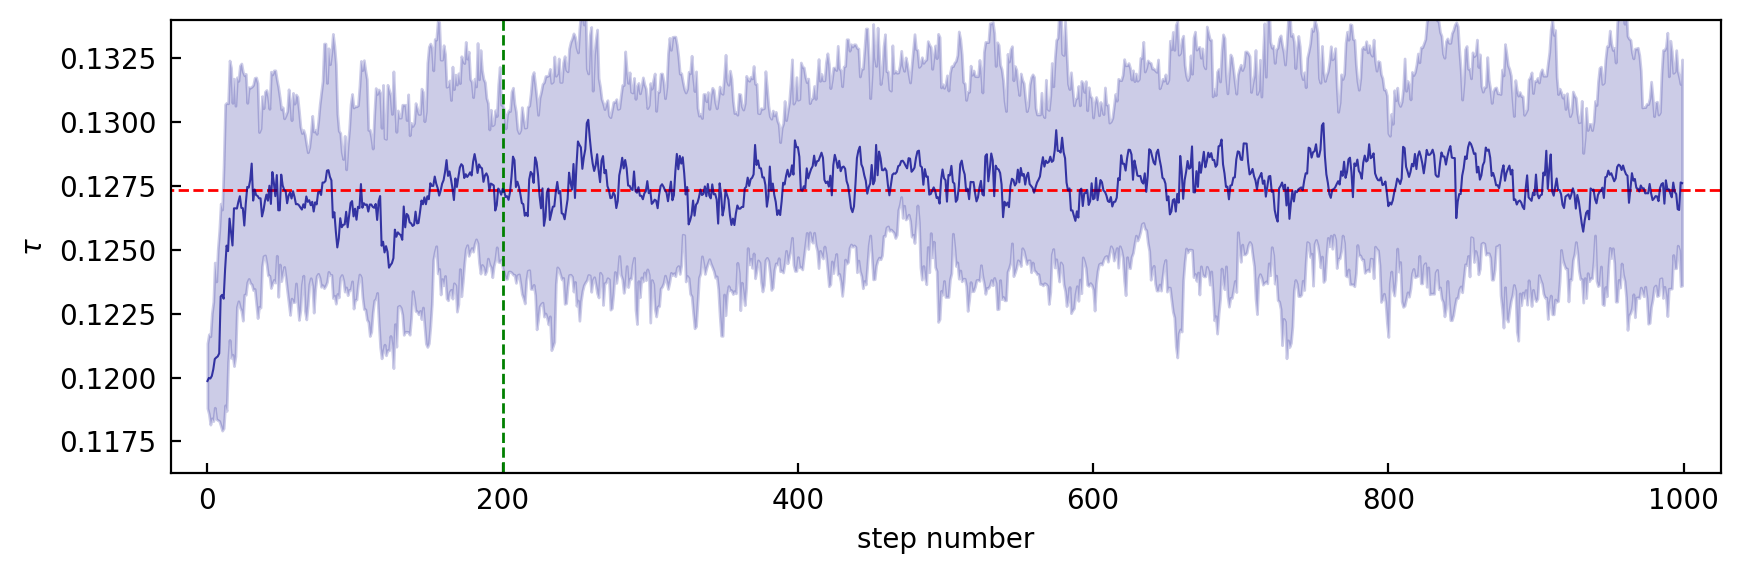

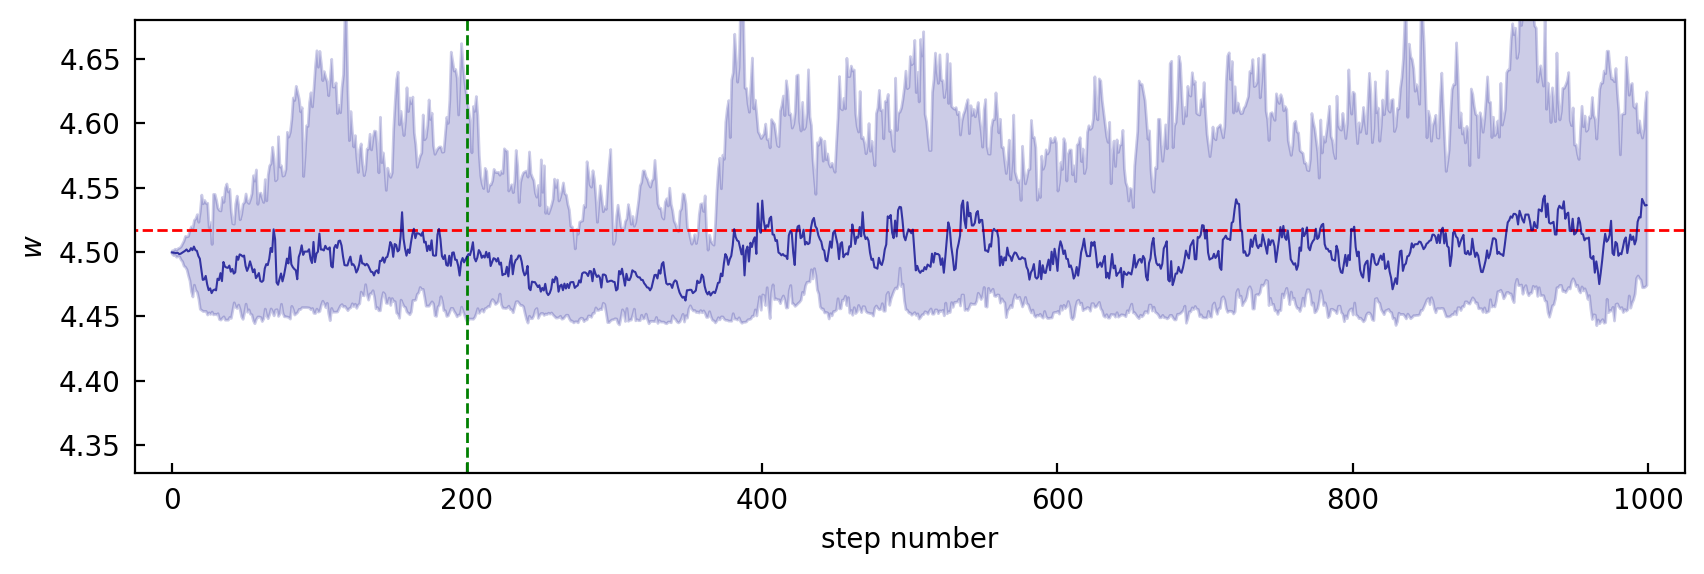

In [248]:
# trace plot
params_lst = [r'\tau', r'w']

plot_trace(results_th22, params_lst)

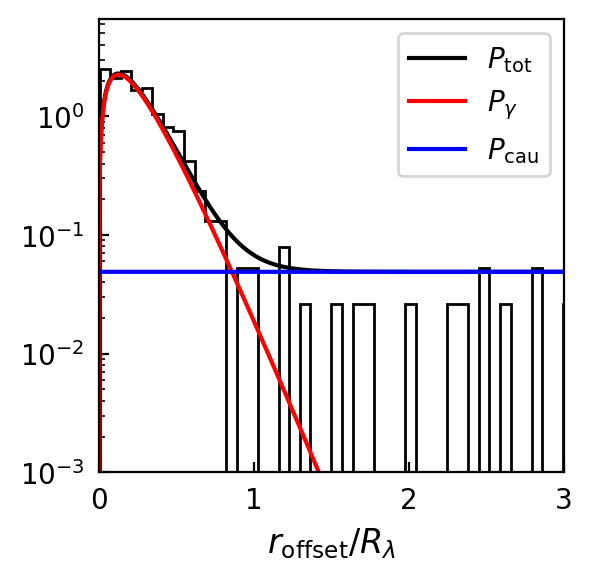

In [254]:
# plot fit

x = np.linspace(0, 3, 10000)
max_loglike, px, pmisc, p2 = lnlike_frlambda(params_fit_th22, x)

plot_fit(px, pmisc, p2, lim=3, scale='log')

### Sigma-clipping in offset distance

In [22]:
from astropy.stats import sigma_clip

In [287]:
def lnlike_frlambda(params, *args):
    
    k = 2
    
    # all the pieces of the model
    offset = args[0]
    x = offset
    
    ### only with tau
    
    
    tau = params
    
    term1 = (1 / (gamma(2) * tau**2)) * x**(k-1) * np.exp(-x/tau)   # pmisc
    
    px = term1.copy()
    
    ####################
    
    #if len(params)==1:
    #    return np.sum(np.log(px)), px
    
    return np.sum(np.log(px)), px, pmisc, p2

#set priors on parameters  
def lnprior_frlambda(params):
    
    #k = 2

    #tau, x0, w, a = params
    #a = 0.22
    tau = params
    
    if ((0.0 < tau <= 1) 
        #& (1e-3 < k < 10)
        #& (1e-3 < x0 < 100)
        #& (0.0 < a <= 1.) 
        #& (0.0001 < w <= 300) 
       ):
        return 0.0
    return -np.inf

def lnprob_frlambda(params, *args):
    
    offset = args[0]
    lp = lnprior_frlambda(params)
    
    if not np.isfinite(lp):
        return -np.inf
    
    ll = lnlike_frlambda(params,offset)[0]
    
    return lp + ll

In [288]:
mask_arr = sigma_clip(misc_cl['offset_Rlambda'], sigma=5.0, maxiters=10)

low_ind = np.invert(mask_arr.mask)
high_ind = mask_arr.mask

roffset_low = misc_cl['offset_Rlambda'][low_ind]
roffset_high = misc_cl['offset_Rlambda'][high_ind]

In [289]:
#let's start the chain the amoeba minimization values
result = [0.1]
ndim,nwalkers = 1, 75  #debugging
pos = [result + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [314]:
#now try to run emcee
sampler_low = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frlambda, args=[roffset_low])
sampler_low.run_mcmc(pos,750, progress=True)

100%|██████████| 750/750 [00:58<00:00, 12.86it/s]


State([[0.12341889]
 [0.12844937]
 [0.12547461]
 [0.129824  ]
 [0.12428505]
 [0.12561417]
 [0.12176419]
 [0.12773027]
 [0.12830545]
 [0.12602966]
 [0.12588645]
 [0.1249726 ]
 [0.1263183 ]
 [0.1258935 ]
 [0.12785346]
 [0.13581194]
 [0.12741136]
 [0.12356625]
 [0.12752655]
 [0.13223694]
 [0.12400617]
 [0.1263861 ]
 [0.12999378]
 [0.12332181]
 [0.12594099]
 [0.12848948]
 [0.13268336]
 [0.12244417]
 [0.12879739]
 [0.13340438]
 [0.12841416]
 [0.12114127]
 [0.13360595]
 [0.12424103]
 [0.12583383]
 [0.12790641]
 [0.12742258]
 [0.12213563]
 [0.124167  ]
 [0.13051046]
 [0.13220052]
 [0.12658632]
 [0.13450789]
 [0.12733148]
 [0.12242479]
 [0.12967868]
 [0.11915526]
 [0.1277409 ]
 [0.13427999]
 [0.12450704]
 [0.1204556 ]
 [0.13067748]
 [0.12805004]
 [0.12785496]
 [0.1288312 ]
 [0.12929825]
 [0.12994222]
 [0.12322492]
 [0.13271638]
 [0.13097142]
 [0.13209895]
 [0.13115937]
 [0.12343274]
 [0.12657265]
 [0.12819115]
 [0.12374897]
 [0.12744931]
 [0.12175229]
 [0.12656407]
 [0.12885847]
 [0.13011038]


In [290]:
#now try to run emcee
sampler_all = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frlambda, args=[misc_cl['offset_Rlambda']])
sampler_all.run_mcmc(pos,750, progress=True)

100%|██████████| 750/750 [00:59<00:00, 12.57it/s]


State([[0.17619908]
 [0.1857723 ]
 [0.17847438]
 [0.17735288]
 [0.17696642]
 [0.18745853]
 [0.18504109]
 [0.17711989]
 [0.18179262]
 [0.18287242]
 [0.18506736]
 [0.18259101]
 [0.1945164 ]
 [0.17764486]
 [0.18543321]
 [0.17593715]
 [0.18416392]
 [0.18142873]
 [0.18118169]
 [0.19327072]
 [0.17879901]
 [0.18263269]
 [0.18345226]
 [0.17704404]
 [0.18416648]
 [0.18534877]
 [0.19287805]
 [0.18411702]
 [0.18490183]
 [0.18794867]
 [0.18414339]
 [0.17239515]
 [0.1886015 ]
 [0.18595702]
 [0.1810949 ]
 [0.18311273]
 [0.18571494]
 [0.18726494]
 [0.18264754]
 [0.17797922]
 [0.18212185]
 [0.17989456]
 [0.18980315]
 [0.18225753]
 [0.17507954]
 [0.18416092]
 [0.18118493]
 [0.18008138]
 [0.197817  ]
 [0.1814293 ]
 [0.17601814]
 [0.18645192]
 [0.17976908]
 [0.18649949]
 [0.19255358]
 [0.1784286 ]
 [0.18100718]
 [0.18062539]
 [0.17551943]
 [0.17890536]
 [0.18795501]
 [0.1887267 ]
 [0.17731828]
 [0.17856197]
 [0.17627054]
 [0.17696545]
 [0.18802561]
 [0.17193804]
 [0.18291813]
 [0.17997423]
 [0.19222032]


In [315]:
samples_low = sampler_low.chain[:,200:, :].reshape((-1, ndim))
samples_low.shape

(41250, 1)

Text(0.5, 0, '$\\tau$')

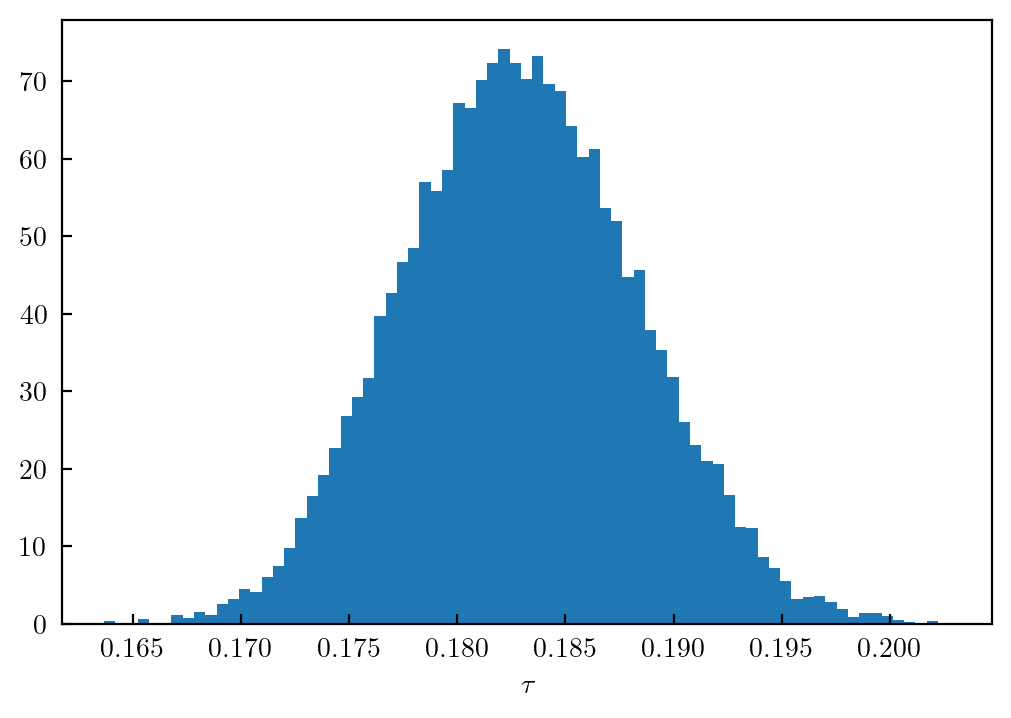

In [146]:
plt.hist(samples_low, bins=75, density=True)
plt.xlabel(r'$\tau$')

In [316]:
params_fit = np.median(samples_low, axis=0)
params_16p = np.percentile(samples_low, 16, axis=0)
params_84p = np.percentile(samples_low, 84, axis=0)

In [317]:
print(params_fit)
print(params_16p)
print(params_84p)

[0.12709028]
[0.12330044]
[0.13083284]


In [318]:
results_low = sampler_low.get_chain()
results_low.shape

(750, 75, 1)

In [296]:
sig_lb_low = np.percentile(results_low, 16, axis=1)
sig_lb_low.reshape(sig_lb_low.shape[0])

array([0.09926377, 0.09925799, 0.09946546, 0.09956523, 0.09957533,
       0.09973558, 0.09985663, 0.09986886, 0.10030163, 0.10018034,
       0.10104175, 0.10164477, 0.1019738 , 0.10210129, 0.1023964 ,
       0.10276207, 0.10366306, 0.10467382, 0.10645672, 0.10720863,
       0.10756486, 0.10780641, 0.10845868, 0.1095771 , 0.11058546,
       0.11119377, 0.11201243, 0.11276968, 0.113042  , 0.11351287,
       0.11476403, 0.11495253, 0.11480369, 0.11640254, 0.11748929,
       0.11820096, 0.11864491, 0.118627  , 0.11965971, 0.11972057,
       0.11948951, 0.11942418, 0.11976601, 0.12029461, 0.12063831,
       0.1204771 , 0.12106118, 0.1212349 , 0.121423  , 0.12123089,
       0.12180703, 0.12147679, 0.12139509, 0.12143814, 0.12122706,
       0.12127408, 0.12116895, 0.12057455, 0.12175358, 0.12158238,
       0.12117018, 0.12115939, 0.12168661, 0.12164791, 0.12279183,
       0.12297478, 0.12268182, 0.12208301, 0.1223315 , 0.1231377 ,
       0.12285746, 0.12305315, 0.12281277, 0.12298583, 0.12302

In [151]:
plot_trace(results_low, params_lst)

NameError: name 'params_lst' is not defined

In [319]:
x = np.linspace(0, 5, 10000)

tau = params_fit.copy()

def p(x):
    
    return (1/tau**2)* x * np.exp(-x/tau)

px = p(x)

Text(0, 0.5, 'density = True')

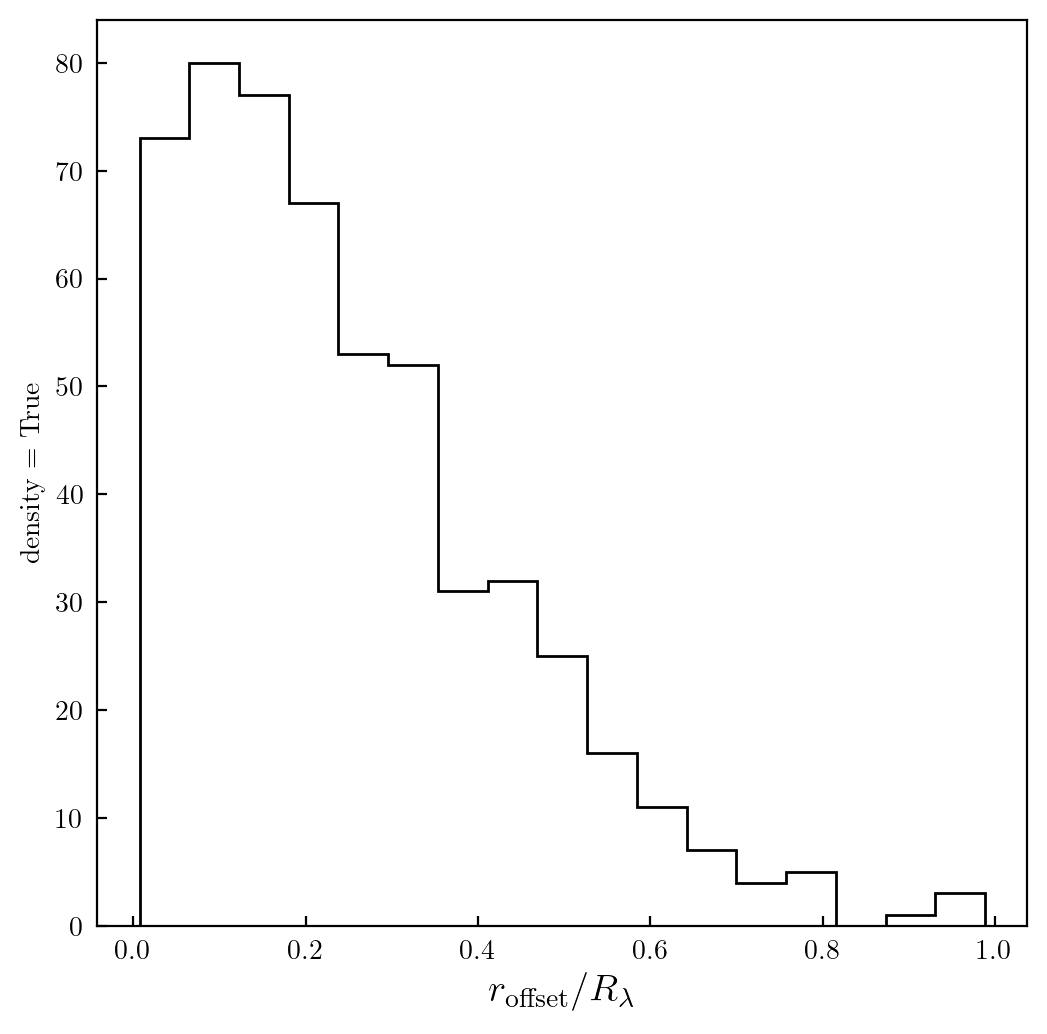

In [320]:
# NOT normalized

#bins = np.linspace(0, np.max(misc_cl['offset_Rlambda']), 100)

plt.figure(figsize=(6,6))
#h = plt.hist(misc_cl['offset_Rlambda'], bins='auto', density=False, histtype='step', fill=False, color='black')
h = plt.hist(roffset_low, bins='auto', density=False, histtype='step', fill=False, color='black')
#plt.plot(x, px, 'r')
plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=14)
plt.ylabel('density = True')
#plt.xlim(0, 1)

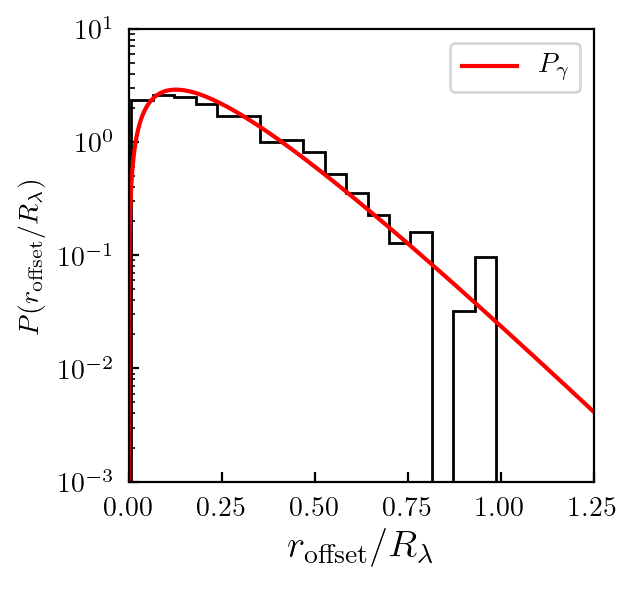

In [326]:
# normalized

plt.figure(figsize=(3,3))
h_norm = plt.hist(roffset_low, bins='auto', density=True, histtype='step', fill=False, color='black')
plt.plot(x, px, 'r', label=r'$P_\gamma$')
plt.xlim(0,1.25)
plt.ylim(1e-3, 10)
plt.yscale('log')
plt.xlabel(r'$r_{\rm offset}/R_\lambda$', fontsize=14)
plt.ylabel(r'$P(r_{\rm offset}/R_\lambda$)')
plt.legend(loc='upper right')
plt.savefig('figures/sigma_clipped_gamma_fit.pdf', bbox_inches='tight', format='pdf')
#plt.xlim(0, 1)

In [178]:
# next, calculate chi2

xos = np.array([])

for i, num in enumerate(h_norm[1][:-1]):
    num2 = h_norm[1][i+1]
    xos = np.append(xos, (num+num2)/2)
    
print
    
yos = h_norm[0]

pxos = p(xos)

In [179]:
ind = 0
norm_const = (h[0][ind] / yos[ind])

# calculate uncertainty
yos_err = np.sqrt(h[0]) / norm_const

In [182]:
from scipy.stats import chi2

def calc_chi2(obs, model, err, npar=3):
    
    obs = np.array(obs)
    model = np.array(model)
    err = np.array(err)
    
    non_zeros = (obs != 0)

    pchi2 = ((obs[non_zeros] - model[non_zeros]) / err[non_zeros])**2
    
    e2 = np.sum(pchi2)
    ddof = pchi2.size - npar   # number of degrees of freedom
    
    pvalue = 1 - chi2.cdf(e2, ddof)
    
    redchi2 = e2 / ddof  # reduced chi2
    print(e2, ddof)
    
    return redchi2, pvalue

In [183]:
redchi2, pvalue = calc_chi2(yos, pxos, yos_err)
redchi2, pvalue

145.3978675055793 31


(4.690253790502559, 1.1102230246251565e-16)

### Outlier Investigation

In [262]:
mask_arr = sigma_clip(misc_cl['offset_Rlambda'], sigma=5.0, maxiters=10)

low_ind = np.invert(mask_arr.mask)
high_ind = mask_arr.mask

low_misc = misc_cl[low_ind]
high_misc = misc_cl[high_ind]

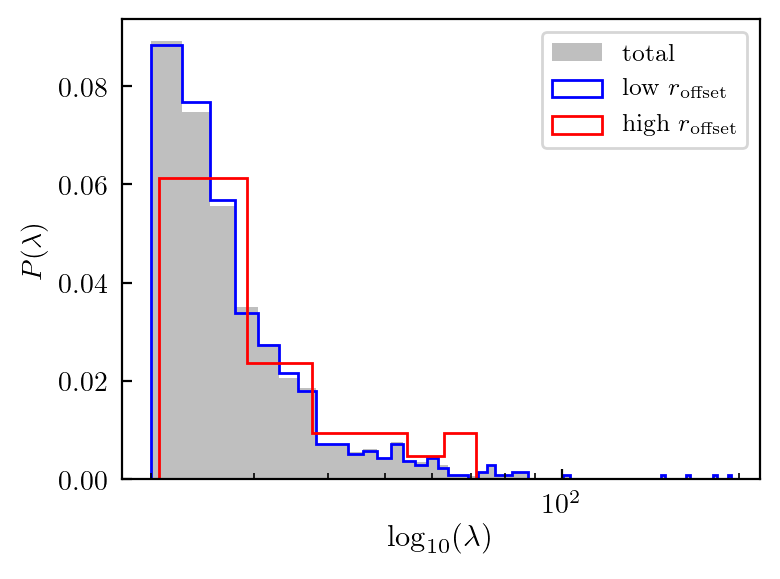

In [202]:
### richness

plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(misc_cl['lambda'], bins='auto', density=True, alpha=0.5, color='grey', label='total')
plt.hist(low_misc['lambda'], bins='auto', density=True, histtype='step', fill=False, color='blue', label=r'low $r_{\rm offset}$')
plt.hist(high_misc['lambda'], bins=6, density=True, histtype='step', color='red', fill=False, label=r'high $r_{\rm offset}$')
plt.xlabel(r'$\log_{10}(\lambda)$', fontsize=11)
plt.ylabel(r'$P(\lambda)$')
plt.xscale('log')
plt.legend(fontsize=9, loc='best')
#plt.show()

plt.tight_layout()

#plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig('figures/outlier_lambda.jpg', format='jpg')

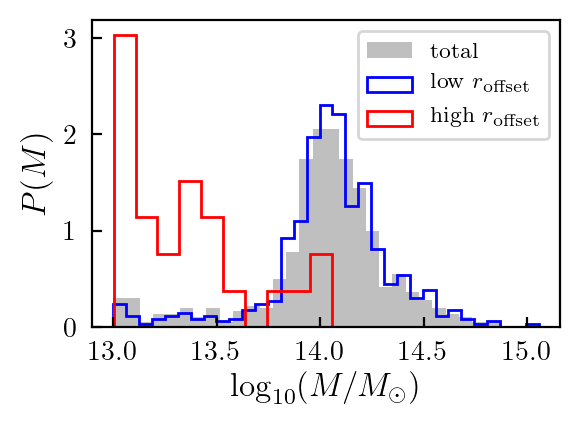

In [313]:
### halo mass

plt.figure(figsize=(3,2.25), tight_layout=True)
plt.hist(np.log10(misc_cl['halo_M']), bins='auto', density=True, alpha=0.5, color='grey', label='total')
plt.hist(np.log10(low_misc['halo_M']), bins='auto', density=True, histtype='step', fill=False, color='blue', label=r'low $r_{\rm offset}$')
plt.hist(np.log10(high_misc['halo_M']), bins=10, density=True, histtype='step', color='red', fill=False, label=r'high $r_{\rm offset}$')
plt.xlabel(r'$\log_{10}({M/M_{\odot}})$', fontsize=12)
plt.ylabel(r'$P(M)$', fontsize=12)
plt.legend(fontsize=8, loc='best')
#plt.show()

plt.tight_layout()

plt.savefig('figures/outlier_halo_mass.pdf', format='pdf')

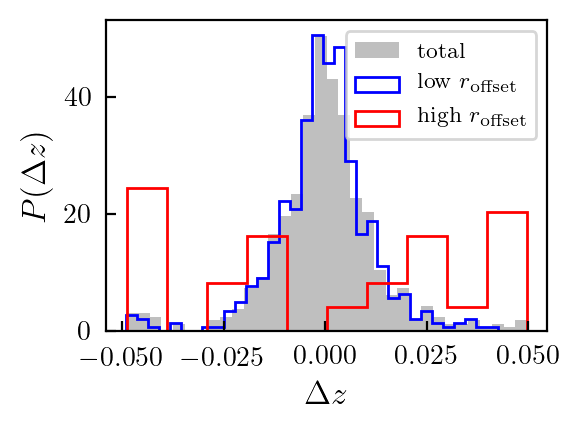

In [312]:
###

plt.figure(figsize=(3,2.25), tight_layout=True)
plt.hist(misc_cl['z_sep'], bins='auto', density=True, alpha=0.5, color='grey', label='total')
plt.hist(low_misc['z_sep'], bins='auto', density=True, histtype='step', fill=False, color='blue', label=r'low $r_{\rm offset}$')
plt.hist(high_misc['z_sep'], bins=10, density=True, histtype='step', color='red', fill=False, label=r'high $r_{\rm offset}$')
plt.xlabel(r'$\Delta z$', fontsize=12)
plt.ylabel(r'$P(\Delta z)$', fontsize=12)
plt.legend(fontsize=8, loc='best')
#plt.show()

plt.tight_layout()

plt.savefig('figures/outlier_delta_z.pdf', format='pdf')

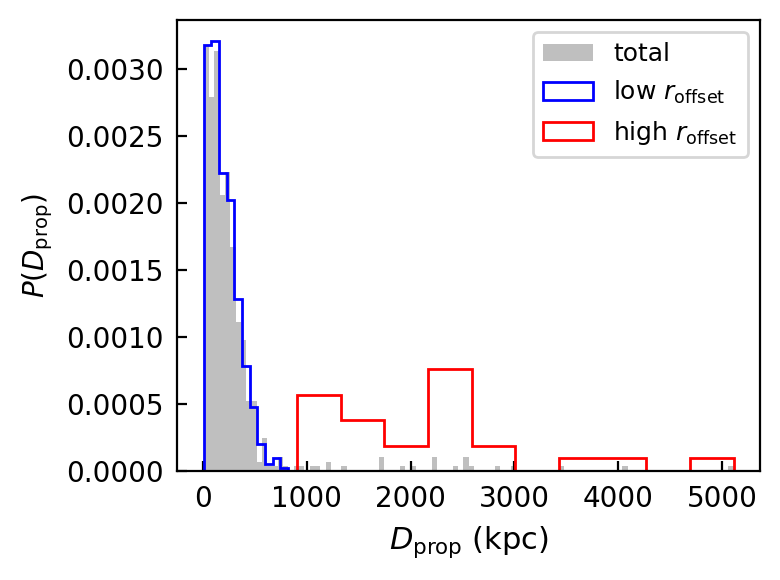

In [101]:
### proper distance

plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(misc_cl['propD_sep'], bins=100, density=True, alpha=0.5, color='grey', label='total')
plt.hist(low_misc['propD_sep'], bins='sturges', density=True, histtype='step', fill=False, color='blue', label=r'low $r_{\rm offset}$')
plt.hist(high_misc['propD_sep'], bins=10, density=True, histtype='step', color='red', fill=False, label=r'high $r_{\rm offset}$')
plt.xlabel(r'$D_{\rm prop}$ (kpc)', fontsize=11)
plt.ylabel(r'$P(D_{\rm prop})$')
plt.legend(fontsize=9, loc='best')
plt.show()

In [263]:
### scatterplot of richness bias

lambda_cent = matched_cl[matched_cl['centered'] == 0]['lambda_cent']

high_lambda_cent = lambda_cent[high_ind]
low_lambda_cent = lambda_cent[low_ind]

high_nonzeros = np.where(high_lambda_cent[:,1] > 0.0)
low_nonzeros = np.where(low_lambda_cent[:,1] > 0.0)

high_l1l2 = high_lambda_cent[:,0]/ high_lambda_cent[:,1]#[high_nonzeros] / high_lambda_cent[:,1][high_nonzeros]
low_l1l2 = low_lambda_cent[:,0]/low_lambda_cent[:,1]#[low_nonzeros] / low_lambda_cent[:,1][low_nonzeros]
print(high_nonzeros[0].shape)


(21,)


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [264]:
nbins = 10
lmdaratio_range = (-0.1,1.5)
#error for mass
r_range = (0., 1)
filt = (low_l1l2 < 4) & (low_misc['offset_Rlambda'] < 1)
n, _ = np.histogram(low_misc['offset_Rlambda'][filt], bins=nbins, range=r_range)
sy, _ = np.histogram(low_misc['offset_Rlambda'][filt], bins=nbins, weights=low_l1l2[filt], range=r_range)
sy2, r_bins = np.histogram(low_misc['offset_Rlambda'][filt], bins=nbins, weights=low_l1l2[filt]**2., range=r_range)
lmdaratio_r_mean = sy / n
lmdaratio_r_std = np.sqrt(sy2/n - lmdaratio_r_mean**2.)

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


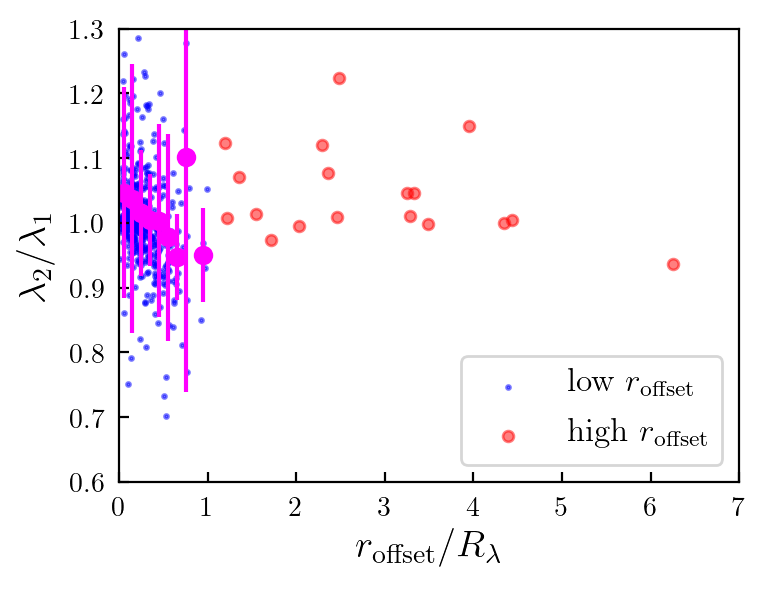

In [273]:
## Plot r_offset against lambda1 / lambda2
plt.figure(figsize=(4,3))
plt.scatter(low_misc['offset_Rlambda'], low_l1l2, c='b', alpha=0.5,s=2, label=r'low $r_{\rm offset}$')
plt.scatter(high_misc['offset_Rlambda'], high_l1l2, c='r', alpha=0.5,s=15, label=r'high $r_{\rm offset}$')
plt.errorbar((r_bins[1:] + r_bins[:-1])/2, lmdaratio_r_mean, yerr=lmdaratio_r_std, c='magenta', fmt='o')
#plt.xlim(r_range)
plt.xlim(0,7)
plt.ylim(0.6, 1.3)
plt.ylabel(r'${\lambda_2} / {\lambda_1}$', fontsize=14)
plt.xlabel(r'$r_{\rm offset}/R_{\lambda}$', fontsize=14)
plt.legend(loc = 'lower right', fontsize=12)
plt.savefig('figures/contaminant_richness_bias.jpg', bbox_inches='tight', format='jpg')
plt.show()

In [173]:
misc_cl[misc_cl['lambda'] > 40].shape

(88, 54)

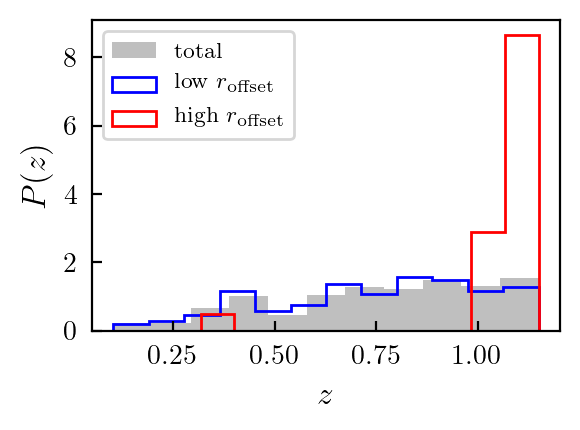

In [350]:
plt.figure(figsize=(3,2.25), tight_layout=True)
plt.hist(misc_cl['z'], bins='auto', density=True, alpha=0.5, color='grey', label='total')
plt.hist(low_misc['z'], bins='auto', density=True, histtype='step', fill=False, color='blue', label=r'low $r_{\rm offset}$')
plt.hist(high_misc['z'], bins=10, density=True, histtype='step', color='red', fill=False, label=r'high $r_{\rm offset}$')
plt.xlabel(r'$z$', fontsize=12)
plt.ylabel(r'$P(z)$', fontsize=12)
plt.legend(fontsize=8, loc='upper left')
#plt.show()

plt.tight_layout()